In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 2

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

##### Now I get indexes for chunks from 2 in 2 days (history doubles the backlook)

In [9]:
index = []

for i in range(days):
    index.append(np.arange(i,len(train),days))

In [10]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [11]:
# Normalised train chunks
X_train = np.array([train_norm[ix].copy() for ix in ordered_index])
Y_train = np.array([train_norm[ordered_index[i+days][-1],3].copy() for i in range(len(ordered_index) - days)])
Y_train = np.expand_dims(Y_train, -1)

In [12]:
# Delete those sequences that doesn't have a -th day in the results
X_train = X_train[:Y_train.shape[0]]

##### Same for test

In [13]:
index = []

for i in range(days):
    index.append(np.arange(i,len(test),days))

In [14]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [15]:
# Normalised test chunks
X_test = np.array([test_norm[ix].copy() for ix in ordered_index])
Y_test = np.array([test_norm[ordered_index[i+days][-1],3].copy() for i in range(len(ordered_index) - days)])
Y_test = np.expand_dims(Y_test, -1)

In [16]:
# Delete those sequences that doesn't have a -th day in the results
X_test = X_test[:Y_test.shape[0]]

# Model selection

##### Model constructor

In [17]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [18]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [19]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [20]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 2s 557us/step - loss: 0.2160 - val_loss: 0.1692
Epoch 2/24
4059/4059 [==============================] - 1s 315us/step - loss: 0.0960 - val_loss: 0.0663
Epoch 3/24
4059/4059 [==============================] - 1s 312us/step - loss: 0.0546 - val_loss: 0.0267
Epoch 4/24
4059/4059 [==============================] - 1s 320us/step - loss: 0.0395 - val_loss: 0.0121
Epoch 5/24
4059/4059 [==============================] - 1s 312us/step - loss: 0.0352 - val_loss: 0.0066
Epoch 6/24
4059/4059 [==============================] - 1s 323us/step - loss: 0.0323 - val_loss: 0.0044
Epoch 7/24
4059/4059 [==============================] - 1s 322us/step - loss: 0.0296 - val_loss: 0.0034
Epoch 8/24
4059/4059 [==============================] - 1s 320us/step - loss: 0.0274 - val

4059/4059 [==============================] - 1s 317us/step - loss: 0.0032 - val_loss: 0.0019
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 3s 736us/step - loss: 0.8218 - val_loss: 0.0090
Epoch 2/24
4059/4059 [==============================] - 2s 533us/step - loss: 0.0165 - val_loss: 0.0024
Epoch 3/24
4059/4059 [==============================] - 2s 536us/step - loss: 0.0082 - val_loss: 0.0015
Epoch 4/24
4059/4059 [==============================] - 2s 532us/step - loss: 0.0059 - val_loss: 0.0019
Epoch 5/24
4059/4059 [==============================] - 2s 531us/step - loss: 0.0051 - val_loss: 0.0019
Epoch 6/24
4059/4059 [==============================] - 2s 535us/step - loss: 0.0050 - val_loss: 0.0019
Epoch 7/24
4059/4059 [==============================] - 2s 528us/step - loss: 0.0046 - val_loss: 0.0017
Epoch 8/24
4059/4059 [==============================] - 2s 533us/step - loss: 0.0045 - val_loss: 0.0018
Epoch 9/24
4059/4059 [======

4059/4059 [==============================] - 1s 359us/step - loss: 0.0558 - val_loss: 0.0397
Epoch 5/24
4059/4059 [==============================] - 1s 353us/step - loss: 0.0213 - val_loss: 0.0208
Epoch 6/24
4059/4059 [==============================] - 1s 358us/step - loss: 0.0255 - val_loss: 0.0422
Epoch 7/24
4059/4059 [==============================] - 1s 353us/step - loss: 0.0362 - val_loss: 0.0519
Epoch 8/24
4059/4059 [==============================] - 1s 354us/step - loss: 0.0332 - val_loss: 0.0492
Epoch 9/24
4059/4059 [==============================] - 1s 355us/step - loss: 0.0381 - val_loss: 0.0573
Epoch 10/24
4059/4059 [==============================] - 1s 358us/step - loss: 0.0473 - val_loss: 0.0648
Epoch 11/24
4059/4059 [==============================] - 1s 361us/step - loss: 0.0444 - val_loss: 0.0554
Epoch 12/24
4059/4059 [==============================] - 1s 357us/step - loss: 0.0454 - val_loss: 0.0663
Epoch 13/24
4059/4059 [==============================] - 1s 352us/step -

4059/4059 [==============================] - 1s 354us/step - loss: 0.0032 - val_loss: 0.0014
Epoch 10/24
4059/4059 [==============================] - 1s 356us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 11/24
4059/4059 [==============================] - 1s 351us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 12/24
4059/4059 [==============================] - 1s 353us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 13/24
4059/4059 [==============================] - 1s 362us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 14/24
4059/4059 [==============================] - 1s 350us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 15/24
4059/4059 [==============================] - 1s 357us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 16/24
4059/4059 [==============================] - 1s 352us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 17/24
4059/4059 [==============================] - 1s 353us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 18/24
4059/4059 [==============================] - 1s 354us/s

Epoch 14/24
4059/4059 [==============================] - 2s 556us/step - loss: 0.0026 - val_loss: 0.0017
Epoch 15/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 16/24
4059/4059 [==============================] - 2s 552us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 17/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 18/24
4059/4059 [==============================] - 2s 553us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 19/24
4059/4059 [==============================] - 2s 558us/step - loss: 0.0026 - val_loss: 0.0019
Epoch 20/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0025 - val_loss: 0.0017
Epoch 21/24
4059/4059 [==============================] - 2s 553us/step - loss: 0.0024 - val_loss: 0.0018
Epoch 22/24
4059/4059 [==============================] - 2s 549us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 23/24
4059/4059 [==============================] 

Epoch 19/24
4059/4059 [==============================] - 2s 553us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 20/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 21/24
4059/4059 [==============================] - 2s 557us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 22/24
4059/4059 [==============================] - 2s 551us/step - loss: 0.0017 - val_loss: 0.0010
Epoch 23/24
4059/4059 [==============================] - 2s 551us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 24/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0015 - val_loss: 8.7132e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 4s 990us/step - loss: 0.1570 - val_loss: 0.0023
Epoch 2/24
4059/4059 [==============================] - 2s 553us/step - loss: 0.0149 - val_loss: 0.0025
Epoch 3/24
4059/4059 [==============================] - 2s 553us/step - loss: 0.0072 - val_loss: 0.0028
Epoch 4

Epoch 24/24
4059/4059 [==============================] - 2s 536us/step - loss: 0.0014 - val_loss: 8.8009e-04

GENERATION 2

Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 4s 1ms/step - loss: 0.0972 - val_loss: 0.0017
Epoch 2/24
4059/4059 [==============================] - 2s 539us/step - loss: 0.0145 - val_loss: 0.0072
Epoch 3/24
4059/4059 [==============================] - 2s 535us/step - loss: 0.0081 - val_loss: 0.0024
Epoch 4/24
4059/4059 [==============================] - 2s 531us/step - loss: 0.0037 - val_loss: 0.0011
Epoch 5/24
4059/4059 [==============================] - 2s 537us/step - loss: 0.0027 - val_loss: 0.0030
Epoch 6/24
4059/4059 [==============================] - 2s 537us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 7/24
4059/4059 [==============================] - 2s 532us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 8/24
4059/4059 [==============================] - 2s 536us/step - loss: 0.0019 - val_loss: 0.0014

4059/4059 [==============================] - 2s 524us/step - loss: 0.0254 - val_loss: 0.0091
Epoch 5/24
4059/4059 [==============================] - 2s 521us/step - loss: 0.0203 - val_loss: 0.0068
Epoch 6/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0162 - val_loss: 0.0050
Epoch 7/24
4059/4059 [==============================] - 2s 521us/step - loss: 0.0129 - val_loss: 0.0037
Epoch 8/24
4059/4059 [==============================] - 2s 524us/step - loss: 0.0104 - val_loss: 0.0027
Epoch 9/24
4059/4059 [==============================] - 2s 522us/step - loss: 0.0084 - val_loss: 0.0021
Epoch 10/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0070 - val_loss: 0.0018
Epoch 11/24
4059/4059 [==============================] - 2s 520us/step - loss: 0.0060 - val_loss: 0.0017
Epoch 12/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0053 - val_loss: 0.0018
Epoch 13/24
4059/4059 [==============================] - 2s 524us/step -

4059/4059 [==============================] - 1s 352us/step - loss: 0.0071 - val_loss: 0.0069
Epoch 10/24
4059/4059 [==============================] - 1s 352us/step - loss: 0.0142 - val_loss: 0.0164
Epoch 11/24
4059/4059 [==============================] - 1s 350us/step - loss: 0.0117 - val_loss: 0.0029
Epoch 12/24
4059/4059 [==============================] - 1s 351us/step - loss: 0.0051 - val_loss: 0.0051
Epoch 13/24
4059/4059 [==============================] - 1s 348us/step - loss: 0.0134 - val_loss: 0.0146
Epoch 14/24
4059/4059 [==============================] - 1s 356us/step - loss: 0.0104 - val_loss: 0.0104
Epoch 15/24
4059/4059 [==============================] - 1s 349us/step - loss: 0.0086 - val_loss: 0.0085
Epoch 16/24
4059/4059 [==============================] - 1s 353us/step - loss: 0.0085 - val_loss: 0.0065
Epoch 17/24
4059/4059 [==============================] - 1s 350us/step - loss: 0.0072 - val_loss: 0.0082
Epoch 18/24
4059/4059 [==============================] - 1s 355us/s

Epoch 14/24
4059/4059 [==============================] - 2s 527us/step - loss: 0.0021 - val_loss: 0.0015
Epoch 15/24
4059/4059 [==============================] - 2s 528us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 16/24
4059/4059 [==============================] - 2s 530us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 17/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 18/24
4059/4059 [==============================] - 2s 530us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 19/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 20/24
4059/4059 [==============================] - 2s 530us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 21/24
4059/4059 [==============================] - 2s 529us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 22/24
4059/4059 [==============================] - 2s 527us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 23/24
4059/4059 [==============================] 

Epoch 19/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0039 - val_loss: 0.0034
Epoch 20/24
4059/4059 [==============================] - 2s 533us/step - loss: 0.0043 - val_loss: 0.0062
Epoch 21/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0043 - val_loss: 0.0032
Epoch 22/24
4059/4059 [==============================] - 2s 534us/step - loss: 0.0036 - val_loss: 0.0041
Epoch 23/24
4059/4059 [==============================] - 2s 528us/step - loss: 0.0051 - val_loss: 0.0034
Epoch 24/24
4059/4059 [==============================] - 2s 527us/step - loss: 0.0044 - val_loss: 0.0039
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 5s 1ms/step - loss: 0.0487 - val_loss: 0.0022
Epoch 2/24
4059/4059 [==============================] - 2s 532us/step - loss: 0.0037 - val_loss: 0.0013
Epoch 3/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0042 - val_loss: 0.0103
Epoch 4/24
40

Epoch 24/24
4059/4059 [==============================] - 2s 398us/step - loss: 0.0239 - val_loss: 0.0150
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 5s 1ms/step - loss: 0.1205 - val_loss: 0.0074
Epoch 2/24
4059/4059 [==============================] - 2s 401us/step - loss: 0.0583 - val_loss: 0.0271
Epoch 3/24
4059/4059 [==============================] - 2s 399us/step - loss: 0.0518 - val_loss: 0.2326
Epoch 4/24
4059/4059 [==============================] - 2s 400us/step - loss: 0.1017 - val_loss: 0.0316
Epoch 5/24
4059/4059 [==============================] - 2s 398us/step - loss: 0.0382 - val_loss: 0.1124
Epoch 6/24
4059/4059 [==============================] - 2s 398us/step - loss: 0.0526 - val_loss: 0.0210
Epoch 7/24
4059/4059 [==============================] - 2s 398us/step - loss: 0.0208 - val_loss: 0.0156
Epoch 8/24
4059/4059 [==============================] - 2s 396us/step - loss: 0.0220 - val_loss: 0.0110
Epoch 9/24
4059/40

Epoch 6/24
4059/4059 [==============================] - 2s 531us/step - loss: 0.0030 - val_loss: 0.0013
Epoch 7/24
4059/4059 [==============================] - 2s 523us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 8/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/24
4059/4059 [==============================] - 2s 530us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 11/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 12/24
4059/4059 [==============================] - 2s 530us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 13/24
4059/4059 [==============================] - 2s 528us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 14/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 15/24
4059/4059 [==============================] - 2s

4059/4059 [==============================] - 2s 494us/step - loss: 0.0659 - val_loss: 0.0385
Epoch 12/24
4059/4059 [==============================] - 2s 495us/step - loss: 0.0659 - val_loss: 0.0394
Epoch 13/24
4059/4059 [==============================] - 2s 492us/step - loss: 0.0659 - val_loss: 0.0394
Epoch 14/24
4059/4059 [==============================] - 2s 496us/step - loss: 0.0659 - val_loss: 0.0396
Epoch 15/24
4059/4059 [==============================] - 2s 493us/step - loss: 0.0659 - val_loss: 0.0390
Epoch 16/24
4059/4059 [==============================] - 2s 493us/step - loss: 0.0659 - val_loss: 0.0388
Epoch 17/24
4059/4059 [==============================] - 2s 497us/step - loss: 0.0659 - val_loss: 0.0386
Epoch 18/24
4059/4059 [==============================] - 2s 490us/step - loss: 0.0659 - val_loss: 0.0387
Epoch 19/24
4059/4059 [==============================] - 2s 493us/step - loss: 0.0659 - val_loss: 0.0386
Epoch 20/24
4059/4059 [==============================] - 2s 491us/s

4059/4059 [==============================] - 2s 561us/step - loss: 0.0012 - val_loss: 7.5718e-04
Epoch 16/24
4059/4059 [==============================] - 2s 560us/step - loss: 0.0011 - val_loss: 7.1725e-04
Epoch 17/24
4059/4059 [==============================] - 2s 559us/step - loss: 0.0011 - val_loss: 7.2568e-04
Epoch 18/24
4059/4059 [==============================] - 2s 564us/step - loss: 0.0012 - val_loss: 8.2823e-04
Epoch 19/24
4059/4059 [==============================] - 2s 556us/step - loss: 0.0011 - val_loss: 6.9985e-04
Epoch 20/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0011 - val_loss: 7.4585e-04
Epoch 21/24
4059/4059 [==============================] - 2s 553us/step - loss: 0.0011 - val_loss: 7.4052e-04
Epoch 22/24
4059/4059 [==============================] - 2s 560us/step - loss: 0.0011 - val_loss: 7.1520e-04
Epoch 23/24
4059/4059 [==============================] - 2s 558us/step - loss: 0.0011 - val_loss: 6.6933e-04
Epoch 24/24
4059/4059 [========

Epoch 19/24
4059/4059 [==============================] - 2s 557us/step - loss: 0.0011 - val_loss: 6.7283e-04
Epoch 20/24
4059/4059 [==============================] - 2s 565us/step - loss: 0.0010 - val_loss: 7.3394e-04
Epoch 21/24
4059/4059 [==============================] - 2s 567us/step - loss: 0.0010 - val_loss: 7.3980e-04
Epoch 22/24
4059/4059 [==============================] - 2s 561us/step - loss: 0.0010 - val_loss: 6.5214e-04
Epoch 23/24
4059/4059 [==============================] - 2s 563us/step - loss: 0.0010 - val_loss: 7.0419e-04
Epoch 24/24
4059/4059 [==============================] - 2s 555us/step - loss: 9.9123e-04 - val_loss: 6.4760e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 7s 2ms/step - loss: 0.0442 - val_loss: 0.0066
Epoch 2/24
4059/4059 [==============================] - 1s 324us/step - loss: 0.0095 - val_loss: 0.0144
Epoch 3/24
4059/4059 [==============================] - 1s 324us/step - loss: 0.0108 - va

4059/4059 [==============================] - 1s 329us/step - loss: 0.0057 - val_loss: 0.0032
Epoch 24/24
4059/4059 [==============================] - 1s 329us/step - loss: 0.0044 - val_loss: 0.0024
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 7s 2ms/step - loss: 0.0598 - val_loss: 0.0018
Epoch 2/24
4059/4059 [==============================] - 1s 325us/step - loss: 0.0077 - val_loss: 0.0022
Epoch 3/24
4059/4059 [==============================] - 1s 329us/step - loss: 0.0095 - val_loss: 0.0222
Epoch 4/24
4059/4059 [==============================] - 1s 323us/step - loss: 0.0113 - val_loss: 0.0059
Epoch 5/24
4059/4059 [==============================] - 1s 322us/step - loss: 0.0053 - val_loss: 0.0067
Epoch 6/24
4059/4059 [==============================] - 1s 322us/step - loss: 0.0050 - val_loss: 0.0065
Epoch 7/24
4059/4059 [==============================] - 1s 327us/step - loss: 0.0078 - val_loss: 0.0122
Epoch 8/24
4059/4059 [=======

4059/4059 [==============================] - 1s 325us/step - loss: 0.0124 - val_loss: 0.0207
Epoch 4/24
4059/4059 [==============================] - 1s 322us/step - loss: 0.0115 - val_loss: 0.0065
Epoch 5/24
4059/4059 [==============================] - 1s 328us/step - loss: 0.0055 - val_loss: 0.0057
Epoch 6/24
4059/4059 [==============================] - 1s 326us/step - loss: 0.0056 - val_loss: 0.0085
Epoch 7/24
4059/4059 [==============================] - 1s 327us/step - loss: 0.0072 - val_loss: 0.0114
Epoch 8/24
4059/4059 [==============================] - 1s 329us/step - loss: 0.0071 - val_loss: 0.0123
Epoch 9/24
4059/4059 [==============================] - 1s 324us/step - loss: 0.0092 - val_loss: 0.0056
Epoch 10/24
4059/4059 [==============================] - 1s 327us/step - loss: 0.0043 - val_loss: 0.0071
Epoch 11/24
4059/4059 [==============================] - 1s 330us/step - loss: 0.0053 - val_loss: 0.0121
Epoch 12/24
4059/4059 [==============================] - 1s 324us/step - 

4059/4059 [==============================] - 2s 565us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/24
4059/4059 [==============================] - 2s 566us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 9/24
4059/4059 [==============================] - 2s 560us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 10/24
4059/4059 [==============================] - 2s 557us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 11/24
4059/4059 [==============================] - 2s 558us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/24
4059/4059 [==============================] - 2s 564us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 13/24
4059/4059 [==============================] - 2s 559us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 14/24
4059/4059 [==============================] - 2s 558us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 15/24
4059/4059 [==============================] - 2s 557us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 16/24
4059/4059 [==============================] - 2s 566us/ste

Epoch 15/24
4059/4059 [==============================] - 2s 558us/step - loss: 0.0338 - val_loss: 0.0082
Epoch 16/24
4059/4059 [==============================] - 2s 563us/step - loss: 0.0337 - val_loss: 0.0069
Epoch 17/24
4059/4059 [==============================] - 2s 559us/step - loss: 0.0328 - val_loss: 0.0075
Epoch 18/24
4059/4059 [==============================] - 2s 560us/step - loss: 0.0299 - val_loss: 0.0070
Epoch 19/24
4059/4059 [==============================] - 2s 566us/step - loss: 0.0298 - val_loss: 0.0059
Epoch 20/24
4059/4059 [==============================] - 2s 560us/step - loss: 0.0307 - val_loss: 0.0057
Epoch 21/24
4059/4059 [==============================] - 2s 559us/step - loss: 0.0286 - val_loss: 0.0059
Epoch 22/24
4059/4059 [==============================] - 2s 561us/step - loss: 0.0293 - val_loss: 0.0050
Epoch 23/24
4059/4059 [==============================] - 2s 565us/step - loss: 0.0275 - val_loss: 0.0054
Epoch 24/24
4059/4059 [==============================] 

Epoch 20/24
4059/4059 [==============================] - 2s 488us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 21/24
4059/4059 [==============================] - 2s 489us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 22/24
4059/4059 [==============================] - 2s 492us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 23/24
4059/4059 [==============================] - 2s 490us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 24/24
4059/4059 [==============================] - 2s 488us/step - loss: 0.0016 - val_loss: 0.0011

GENERATION 7

Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 10s 2ms/step - loss: 0.0683 - val_loss: 0.0264
Epoch 2/24
4059/4059 [==============================] - 2s 525us/step - loss: 0.0648 - val_loss: 0.0433
Epoch 3/24
4059/4059 [==============================] - 2s 533us/step - loss: 0.0574 - val_loss: 0.0202
Epoch 4/24
4059/4059 [==============================] - 2s 526us/step - loss: 0.0406 - val_loss: 0.006

4059/4059 [==============================] - 2s 572us/step - loss: 0.0011 - val_loss: 7.0316e-04
Epoch 24/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0011 - val_loss: 8.9537e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 11s 3ms/step - loss: 0.1018 - val_loss: 0.0013
Epoch 2/24
4059/4059 [==============================] - 2s 584us/step - loss: 0.0081 - val_loss: 0.0413
Epoch 3/24
4059/4059 [==============================] - 2s 577us/step - loss: 0.0099 - val_loss: 0.0022
Epoch 4/24
4059/4059 [==============================] - 2s 577us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 5/24
4059/4059 [==============================] - 2s 579us/step - loss: 0.0028 - val_loss: 0.0074
Epoch 6/24
4059/4059 [==============================] - 2s 578us/step - loss: 0.0102 - val_loss: 0.0087
Epoch 7/24
4059/4059 [==============================] - 2s 572us/step - loss: 0.0036 - val_loss: 0.0012
Epoch 8/24
4059/4059

4059/4059 [==============================] - 2s 581us/step - loss: 0.0063 - val_loss: 0.0010
Epoch 4/24
4059/4059 [==============================] - 2s 580us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 5/24
4059/4059 [==============================] - 2s 580us/step - loss: 0.0035 - val_loss: 0.0088
Epoch 6/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0048 - val_loss: 0.0025
Epoch 7/24
4059/4059 [==============================] - 2s 576us/step - loss: 0.0021 - val_loss: 9.0048e-04
Epoch 8/24
4059/4059 [==============================] - 2s 577us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/24
4059/4059 [==============================] - 2s 578us/step - loss: 0.0044 - val_loss: 0.0067
Epoch 10/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0028 - val_loss: 0.0010
Epoch 11/24
4059/4059 [==============================] - 2s 577us/step - loss: 0.0018 - val_loss: 8.3117e-04
Epoch 12/24
4059/4059 [==============================] - 2s 581us

4059/4059 [==============================] - 2s 577us/step - loss: 0.0049 - val_loss: 0.0016
Epoch 8/24
4059/4059 [==============================] - 2s 572us/step - loss: 0.0040 - val_loss: 0.0015
Epoch 9/24
4059/4059 [==============================] - 2s 568us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 10/24
4059/4059 [==============================] - 2s 574us/step - loss: 0.0034 - val_loss: 0.0016
Epoch 11/24
4059/4059 [==============================] - 2s 574us/step - loss: 0.0031 - val_loss: 0.0016
Epoch 12/24
4059/4059 [==============================] - 2s 574us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 13/24
4059/4059 [==============================] - 2s 577us/step - loss: 0.0031 - val_loss: 0.0017
Epoch 14/24
4059/4059 [==============================] - 2s 573us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 15/24
4059/4059 [==============================] - 2s 573us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 16/24
4059/4059 [==============================] - 2s 576us/ste

4059/4059 [==============================] - 2s 575us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 12/24
4059/4059 [==============================] - 2s 577us/step - loss: 0.0017 - val_loss: 9.5181e-04
Epoch 13/24
4059/4059 [==============================] - 2s 575us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 14/24
4059/4059 [==============================] - 2s 572us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 15/24
4059/4059 [==============================] - 2s 576us/step - loss: 0.0016 - val_loss: 8.7995e-04
Epoch 16/24
4059/4059 [==============================] - 2s 576us/step - loss: 0.0016 - val_loss: 9.9725e-04
Epoch 17/24
4059/4059 [==============================] - 2s 578us/step - loss: 0.0016 - val_loss: 8.8523e-04
Epoch 18/24
4059/4059 [==============================] - 2s 572us/step - loss: 0.0015 - val_loss: 9.3100e-04
Epoch 19/24
4059/4059 [==============================] - 2s 575us/step - loss: 0.0015 - val_loss: 8.4094e-04
Epoch 20/24
4059/4059 [====================

4059/4059 [==============================] - 2s 558us/step - loss: 0.0078 - val_loss: 0.0049
Epoch 16/24
4059/4059 [==============================] - 2s 548us/step - loss: 0.0067 - val_loss: 0.0082
Epoch 17/24
4059/4059 [==============================] - 2s 551us/step - loss: 0.0069 - val_loss: 0.0058
Epoch 18/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0065 - val_loss: 0.0104
Epoch 19/24
4059/4059 [==============================] - 2s 556us/step - loss: 0.0077 - val_loss: 0.0110
Epoch 20/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0081 - val_loss: 0.0087
Epoch 21/24
4059/4059 [==============================] - 2s 550us/step - loss: 0.0077 - val_loss: 0.0057
Epoch 22/24
4059/4059 [==============================] - 2s 552us/step - loss: 0.0055 - val_loss: 0.0054
Epoch 23/24
4059/4059 [==============================] - 2s 554us/step - loss: 0.0069 - val_loss: 0.0026
Epoch 24/24
4059/4059 [==============================] - 2s 553us/s

4059/4059 [==============================] - 2s 577us/step - loss: 0.0014 - val_loss: 7.2679e-04
Epoch 20/24
4059/4059 [==============================] - 2s 573us/step - loss: 0.0014 - val_loss: 8.0908e-04
Epoch 21/24
4059/4059 [==============================] - 2s 575us/step - loss: 0.0014 - val_loss: 7.4463e-04
Epoch 22/24
4059/4059 [==============================] - 2s 577us/step - loss: 0.0013 - val_loss: 7.7939e-04
Epoch 23/24
4059/4059 [==============================] - 2s 574us/step - loss: 0.0014 - val_loss: 7.0913e-04
Epoch 24/24
4059/4059 [==============================] - 2s 578us/step - loss: 0.0013 - val_loss: 7.4849e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 14s 4ms/step - loss: 0.0585 - val_loss: 0.0173
Epoch 2/24
4059/4059 [==============================] - 2s 574us/step - loss: 0.0080 - val_loss: 0.0060
Epoch 3/24
4059/4059 [==============================] - 2s 575us/step - loss: 0.0043 - val_loss: 0.0013


4059/4059 [==============================] - 2s 531us/step - loss: 0.0039 - val_loss: 9.5276e-04
Epoch 24/24
4059/4059 [==============================] - 2s 521us/step - loss: 0.0020 - val_loss: 7.3586e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 15s 4ms/step - loss: nan - val_loss: nan
Epoch 2/24
4059/4059 [==============================] - 2s 523us/step - loss: nan - val_loss: nan
Epoch 3/24
4059/4059 [==============================] - 2s 519us/step - loss: nan - val_loss: nan
Epoch 4/24
4059/4059 [==============================] - 2s 528us/step - loss: nan - val_loss: nan
Epoch 5/24
4059/4059 [==============================] - 2s 530us/step - loss: nan - val_loss: nan
Epoch 6/24
4059/4059 [==============================] - 2s 524us/step - loss: nan - val_loss: nan
Epoch 7/24
4059/4059 [==============================] - 2s 527us/step - loss: nan - val_loss: nan
Epoch 8/24
4059/4059 [==============================] - 2s 519

4059/4059 [==============================] - 2s 509us/step - loss: 0.0076 - val_loss: 0.0012
Epoch 7/24
4059/4059 [==============================] - 2s 507us/step - loss: 0.0071 - val_loss: 0.0012
Epoch 8/24
4059/4059 [==============================] - 2s 520us/step - loss: 0.0069 - val_loss: 0.0012
Epoch 9/24
4059/4059 [==============================] - 2s 507us/step - loss: 0.0065 - val_loss: 0.0012
Epoch 10/24
4059/4059 [==============================] - 2s 505us/step - loss: 0.0060 - val_loss: 0.0012
Epoch 11/24
4059/4059 [==============================] - 2s 511us/step - loss: 0.0058 - val_loss: 0.0011
Epoch 12/24
4059/4059 [==============================] - 2s 515us/step - loss: 0.0056 - val_loss: 0.0011
Epoch 13/24
4059/4059 [==============================] - 2s 509us/step - loss: 0.0058 - val_loss: 0.0011
Epoch 14/24
4059/4059 [==============================] - 2s 510us/step - loss: 0.0055 - val_loss: 0.0011
Epoch 15/24
4059/4059 [==============================] - 2s 517us/step

Epoch 11/24
4059/4059 [==============================] - 2s 577us/step - loss: 0.0014 - val_loss: 0.0010
Epoch 12/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 13/24
4059/4059 [==============================] - 2s 580us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 14/24
4059/4059 [==============================] - 2s 580us/step - loss: 0.0012 - val_loss: 8.2473e-04
Epoch 15/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0011 - val_loss: 8.2749e-04
Epoch 16/24
4059/4059 [==============================] - 2s 584us/step - loss: 0.0011 - val_loss: 7.4908e-04
Epoch 17/24
4059/4059 [==============================] - 2s 578us/step - loss: 0.0011 - val_loss: 7.0620e-04
Epoch 18/24
4059/4059 [==============================] - 2s 577us/step - loss: 0.0011 - val_loss: 7.8366e-04
Epoch 19/24
4059/4059 [==============================] - 2s 583us/step - loss: 0.0011 - val_loss: 7.7576e-04
Epoch 20/24
4059/4059 [========

4059/4059 [==============================] - 2s 574us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 16/24
4059/4059 [==============================] - 2s 575us/step - loss: 0.0032 - val_loss: 0.0022
Epoch 17/24
4059/4059 [==============================] - 2s 576us/step - loss: 0.0031 - val_loss: 0.0022
Epoch 18/24
4059/4059 [==============================] - 2s 573us/step - loss: 0.0030 - val_loss: 0.0022
Epoch 19/24
4059/4059 [==============================] - 2s 574us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 20/24
4059/4059 [==============================] - 2s 580us/step - loss: 0.0031 - val_loss: 0.0021
Epoch 21/24
4059/4059 [==============================] - 2s 579us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 22/24
4059/4059 [==============================] - 2s 578us/step - loss: 0.0031 - val_loss: 0.0022
Epoch 23/24
4059/4059 [==============================] - 2s 591us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 24/24
4059/4059 [==============================] - 2s 577us/s

4059/4059 [==============================] - 2s 572us/step - loss: nan - val_loss: nan
Epoch 22/24
4059/4059 [==============================] - 2s 581us/step - loss: nan - val_loss: nan
Epoch 23/24
4059/4059 [==============================] - 2s 574us/step - loss: nan - val_loss: nan
Epoch 24/24
4059/4059 [==============================] - 2s 578us/step - loss: nan - val_loss: nan
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 18s 4ms/step - loss: nan - val_loss: nan
Epoch 2/24
4059/4059 [==============================] - 2s 392us/step - loss: nan - val_loss: nan
Epoch 3/24
4059/4059 [==============================] - 2s 387us/step - loss: nan - val_loss: nan
Epoch 4/24
4059/4059 [==============================] - 2s 389us/step - loss: nan - val_loss: nan
Epoch 5/24
4059/4059 [==============================] - 2s 385us/step - loss: nan - val_loss: nan
Epoch 6/24
4059/4059 [==============================] - 2s 388us/step - loss: na

Epoch 2/24
4059/4059 [==============================] - 1s 334us/step - loss: 0.0125 - val_loss: 0.0011
Epoch 3/24
4059/4059 [==============================] - 1s 340us/step - loss: 0.0066 - val_loss: 0.0109
Epoch 4/24
4059/4059 [==============================] - 1s 332us/step - loss: 0.0045 - val_loss: 0.0018
Epoch 5/24
4059/4059 [==============================] - 1s 332us/step - loss: 0.0034 - val_loss: 0.0047
Epoch 6/24
4059/4059 [==============================] - 1s 334us/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/24
4059/4059 [==============================] - 1s 331us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/24
4059/4059 [==============================] - 1s 333us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/24
4059/4059 [==============================] - 1s 331us/step - loss: 0.0020 - val_loss: 0.0011
Epoch 10/24
4059/4059 [==============================] - 1s 339us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 11/24
4059/4059 [==============================] - 1s 335

4059/4059 [==============================] - 1s 332us/step - loss: 0.0080 - val_loss: 0.0019
Epoch 7/24
4059/4059 [==============================] - 1s 335us/step - loss: 0.0063 - val_loss: 0.0015
Epoch 8/24
4059/4059 [==============================] - 1s 332us/step - loss: 0.0051 - val_loss: 0.0014
Epoch 9/24
4059/4059 [==============================] - 1s 330us/step - loss: 0.0048 - val_loss: 0.0014
Epoch 10/24
4059/4059 [==============================] - 1s 329us/step - loss: 0.0043 - val_loss: 0.0014
Epoch 11/24
4059/4059 [==============================] - 1s 330us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 12/24
4059/4059 [==============================] - 1s 331us/step - loss: 0.0038 - val_loss: 0.0015
Epoch 13/24
4059/4059 [==============================] - 1s 330us/step - loss: 0.0038 - val_loss: 0.0015
Epoch 14/24
4059/4059 [==============================] - 1s 332us/step - loss: 0.0037 - val_loss: 0.0016
Epoch 15/24
4059/4059 [==============================] - 1s 331us/step

Epoch 11/24
4059/4059 [==============================] - 1s 353us/step - loss: 0.0020 - val_loss: 0.0011
Epoch 12/24
4059/4059 [==============================] - 1s 367us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 13/24
4059/4059 [==============================] - 1s 354us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 14/24
4059/4059 [==============================] - 1s 361us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 15/24
4059/4059 [==============================] - 1s 358us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 16/24
4059/4059 [==============================] - 1s 353us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 17/24
4059/4059 [==============================] - 1s 360us/step - loss: 0.0019 - val_loss: 9.9965e-04
Epoch 18/24
4059/4059 [==============================] - 1s 353us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 19/24
4059/4059 [==============================] - 1s 356us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 20/24
4059/4059 [============================

4059/4059 [==============================] - 2s 576us/step - loss: 0.0052 - val_loss: 0.0063
Epoch 15/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0039 - val_loss: 0.0055
Epoch 16/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0031 - val_loss: 0.0045
Epoch 17/24
4059/4059 [==============================] - 2s 583us/step - loss: 0.0033 - val_loss: 0.0046
Epoch 18/24
4059/4059 [==============================] - 2s 589us/step - loss: 0.0021 - val_loss: 0.0031
Epoch 19/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0025 - val_loss: 0.0063
Epoch 20/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0034 - val_loss: 0.0062
Epoch 21/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0033 - val_loss: 0.0044
Epoch 22/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0034 - val_loss: 0.0038
Epoch 23/24
4059/4059 [==============================] - 2s 577us/s

4059/4059 [==============================] - 2s 526us/step - loss: 0.0063 - val_loss: 0.0090
Epoch 20/24
4059/4059 [==============================] - 2s 518us/step - loss: 0.0068 - val_loss: 0.0033
Epoch 21/24
4059/4059 [==============================] - 2s 527us/step - loss: 0.0052 - val_loss: 0.0064
Epoch 22/24
4059/4059 [==============================] - 2s 522us/step - loss: 0.0062 - val_loss: 0.0047
Epoch 23/24
4059/4059 [==============================] - 2s 523us/step - loss: 0.0047 - val_loss: 0.0101
Epoch 24/24
4059/4059 [==============================] - 2s 518us/step - loss: 0.0059 - val_loss: 0.0026
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 24s 6ms/step - loss: nan - val_loss: nan
Epoch 2/24
4059/4059 [==============================] - 2s 523us/step - loss: nan - val_loss: nan
Epoch 3/24
4059/4059 [==============================] - 2s 523us/step - loss: nan - val_loss: nan
Epoch 4/24
4059/4059 [====================

4059/4059 [==============================] - 25s 6ms/step - loss: 0.0517 - val_loss: 0.0165
Epoch 2/24
4059/4059 [==============================] - 2s 497us/step - loss: 0.0083 - val_loss: 0.0067
Epoch 3/24
4059/4059 [==============================] - 2s 499us/step - loss: 0.0046 - val_loss: 0.0011
Epoch 4/24
4059/4059 [==============================] - 2s 493us/step - loss: 0.0027 - val_loss: 0.0012
Epoch 5/24
4059/4059 [==============================] - 2s 495us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 6/24
4059/4059 [==============================] - 2s 497us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 7/24
4059/4059 [==============================] - 2s 494us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/24
4059/4059 [==============================] - 2s 494us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/24
4059/4059 [==============================] - 2s 494us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/24
4059/4059 [==============================] - 2s 501us/step - los

Epoch 5/24
4059/4059 [==============================] - 2s 589us/step - loss: 0.0028 - val_loss: 0.0042
Epoch 6/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0024 - val_loss: 9.7183e-04
Epoch 7/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0020 - val_loss: 0.0011
Epoch 8/24
4059/4059 [==============================] - 2s 583us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 11/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 12/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 13/24
4059/4059 [==============================] - 2s 591us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 14/24
4059/4059 [==============================] -

4059/4059 [==============================] - 2s 587us/step - loss: 0.0098 - val_loss: 0.0103
Epoch 10/24
4059/4059 [==============================] - 2s 588us/step - loss: 0.0106 - val_loss: 0.0138
Epoch 11/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0120 - val_loss: 0.0118
Epoch 12/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0104 - val_loss: 0.0168
Epoch 13/24
4059/4059 [==============================] - 2s 590us/step - loss: 0.0156 - val_loss: 0.0155
Epoch 14/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0086 - val_loss: 0.0120
Epoch 15/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0110 - val_loss: 0.0112
Epoch 16/24
4059/4059 [==============================] - 2s 590us/step - loss: 0.0089 - val_loss: 0.0118
Epoch 17/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0151 - val_loss: 0.1166
Epoch 18/24
4059/4059 [==============================] - 2s 591us/s

4059/4059 [==============================] - 2s 590us/step - loss: 0.0012 - val_loss: 8.2871e-04
Epoch 14/24
4059/4059 [==============================] - 2s 592us/step - loss: 0.0012 - val_loss: 8.1006e-04
Epoch 15/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0012 - val_loss: 9.2699e-04
Epoch 16/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0012 - val_loss: 7.3046e-04
Epoch 17/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0011 - val_loss: 8.0987e-04
Epoch 18/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0011 - val_loss: 7.2456e-04
Epoch 19/24
4059/4059 [==============================] - 2s 594us/step - loss: 0.0011 - val_loss: 8.0192e-04
Epoch 20/24
4059/4059 [==============================] - 2s 583us/step - loss: 0.0011 - val_loss: 7.0145e-04
Epoch 21/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0010 - val_loss: 7.6586e-04
Epoch 22/24
4059/4059 [========

4059/4059 [==============================] - 2s 563us/step - loss: 0.0011 - val_loss: 6.9079e-04
Epoch 17/24
4059/4059 [==============================] - 2s 561us/step - loss: 0.0011 - val_loss: 7.5708e-04
Epoch 18/24
4059/4059 [==============================] - 2s 564us/step - loss: 0.0011 - val_loss: 7.1263e-04
Epoch 19/24
4059/4059 [==============================] - 2s 571us/step - loss: 0.0011 - val_loss: 6.7203e-04
Epoch 20/24
4059/4059 [==============================] - 2s 567us/step - loss: 0.0010 - val_loss: 8.1595e-04
Epoch 21/24
4059/4059 [==============================] - 2s 562us/step - loss: 0.0010 - val_loss: 6.5910e-04
Epoch 22/24
4059/4059 [==============================] - 2s 566us/step - loss: 0.0010 - val_loss: 6.8107e-04
Epoch 23/24
4059/4059 [==============================] - 2s 565us/step - loss: 9.9977e-04 - val_loss: 9.4598e-04
Epoch 24/24
4059/4059 [==============================] - 2s 566us/step - loss: 0.0010 - val_loss: 6.6773e-04
Train on 4059 samples, vali

Epoch 20/24
4059/4059 [==============================] - 2s 480us/step - loss: 0.0014 - val_loss: 8.9870e-04
Epoch 21/24
4059/4059 [==============================] - 2s 481us/step - loss: 0.0014 - val_loss: 8.7271e-04
Epoch 22/24
4059/4059 [==============================] - 2s 484us/step - loss: 0.0014 - val_loss: 8.5892e-04
Epoch 23/24
4059/4059 [==============================] - 2s 480us/step - loss: 0.0013 - val_loss: 7.8530e-04
Epoch 24/24
4059/4059 [==============================] - 2s 477us/step - loss: 0.0014 - val_loss: 7.5151e-04
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 31s 8ms/step - loss: 0.0754 - val_loss: 0.0045
Epoch 2/24
4059/4059 [==============================] - 2s 511us/step - loss: 0.0106 - val_loss: 0.0084
Epoch 3/24
4059/4059 [==============================] - 2s 512us/step - loss: 0.0069 - val_loss: 0.0096
Epoch 4/24
4059/4059 [==============================] - 2s 508us/step - loss: 0.0043 - val_loss: 

4059/4059 [==============================] - 34s 8ms/step - loss: 0.0569 - val_loss: 0.0148
Epoch 2/24
4059/4059 [==============================] - 2s 589us/step - loss: 0.0096 - val_loss: 0.0043
Epoch 3/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0048 - val_loss: 0.0017
Epoch 4/24
4059/4059 [==============================] - 2s 598us/step - loss: 0.0032 - val_loss: 0.0010
Epoch 5/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0024 - val_loss: 0.0040
Epoch 6/24
4059/4059 [==============================] - 2s 589us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0017 - val_loss: 8.3524e-04
Epoch 8/24
4059/4059 [==============================] - 2s 588us/step - loss: 0.0015 - val_loss: 9.0336e-04
Epoch 9/24
4059/4059 [==============================] - 2s 597us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/24
4059/4059 [==============================] - 2s 592us/st

4059/4059 [==============================] - 1s 347us/step - loss: 0.0122 - val_loss: 0.0093
Epoch 6/24
4059/4059 [==============================] - 1s 349us/step - loss: 0.0077 - val_loss: 0.0159
Epoch 7/24
4059/4059 [==============================] - 1s 348us/step - loss: 0.0089 - val_loss: 0.0151
Epoch 8/24
4059/4059 [==============================] - 1s 350us/step - loss: 0.0082 - val_loss: 0.0106
Epoch 9/24
4059/4059 [==============================] - 1s 347us/step - loss: 0.0083 - val_loss: 0.0134
Epoch 10/24
4059/4059 [==============================] - 1s 365us/step - loss: 0.0081 - val_loss: 0.0073
Epoch 11/24
4059/4059 [==============================] - 1s 368us/step - loss: 0.0063 - val_loss: 0.0109
Epoch 12/24
4059/4059 [==============================] - 1s 351us/step - loss: 0.0080 - val_loss: 0.0068
Epoch 13/24
4059/4059 [==============================] - 1s 341us/step - loss: 0.0053 - val_loss: 0.0127
Epoch 14/24
4059/4059 [==============================] - 1s 362us/step 

4059/4059 [==============================] - 1s 342us/step - loss: 0.0120 - val_loss: 0.0202
Epoch 11/24
4059/4059 [==============================] - 1s 339us/step - loss: 0.0277 - val_loss: 0.0192
Epoch 12/24
4059/4059 [==============================] - 1s 338us/step - loss: 0.0063 - val_loss: 0.0014
Epoch 13/24
4059/4059 [==============================] - 1s 343us/step - loss: 0.0113 - val_loss: 0.0135
Epoch 14/24
4059/4059 [==============================] - 1s 340us/step - loss: 0.0114 - val_loss: 0.0038
Epoch 15/24
4059/4059 [==============================] - 1s 339us/step - loss: 0.0132 - val_loss: 0.0279
Epoch 16/24
4059/4059 [==============================] - 1s 340us/step - loss: 0.0116 - val_loss: 0.0015
Epoch 17/24
4059/4059 [==============================] - 1s 340us/step - loss: 0.0089 - val_loss: 0.0030
Epoch 18/24
4059/4059 [==============================] - 1s 347us/step - loss: 0.0086 - val_loss: 0.0068
Epoch 19/24
4059/4059 [==============================] - 1s 343us/s

4059/4059 [==============================] - 2s 582us/step - loss: 0.0011 - val_loss: 7.4103e-04
Epoch 15/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 16/24
4059/4059 [==============================] - 2s 579us/step - loss: 0.0012 - val_loss: 7.2339e-04
Epoch 17/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0011 - val_loss: 7.5339e-04
Epoch 18/24
4059/4059 [==============================] - 2s 584us/step - loss: 0.0011 - val_loss: 7.2344e-04
Epoch 19/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0011 - val_loss: 8.3925e-04
Epoch 20/24
4059/4059 [==============================] - 2s 583us/step - loss: 0.0011 - val_loss: 7.4018e-04
Epoch 21/24
4059/4059 [==============================] - 2s 591us/step - loss: 0.0010 - val_loss: 6.9482e-04
Epoch 22/24
4059/4059 [==============================] - 2s 589us/step - loss: 0.0010 - val_loss: 6.9398e-04
Epoch 23/24
4059/4059 [============

4059/4059 [==============================] - 2s 427us/step - loss: 0.0658 - val_loss: 0.0390
Epoch 19/24
4059/4059 [==============================] - 2s 428us/step - loss: 0.0659 - val_loss: 0.0387
Epoch 20/24
4059/4059 [==============================] - 2s 431us/step - loss: 0.0659 - val_loss: 0.0383
Epoch 21/24
4059/4059 [==============================] - 2s 427us/step - loss: 0.0659 - val_loss: 0.0389
Epoch 22/24
4059/4059 [==============================] - 2s 426us/step - loss: 0.0658 - val_loss: 0.0383
Epoch 23/24
4059/4059 [==============================] - 2s 426us/step - loss: 0.0659 - val_loss: 0.0380
Epoch 24/24
4059/4059 [==============================] - 2s 426us/step - loss: 0.0658 - val_loss: 0.0386
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 39s 10ms/step - loss: 0.1599 - val_loss: 0.0975
Epoch 2/24
4059/4059 [==============================] - 2s 426us/step - loss: 0.0719 - val_loss: 0.0511
Epoch 3/24
4059/4059 [

Epoch 23/24
4059/4059 [==============================] - 2s 514us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 24/24
4059/4059 [==============================] - 2s 514us/step - loss: 0.0013 - val_loss: 0.0010
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 42s 10ms/step - loss: 0.1187 - val_loss: 0.0306
Epoch 2/24
4059/4059 [==============================] - 2s 571us/step - loss: 0.0507 - val_loss: 0.0204
Epoch 3/24
4059/4059 [==============================] - 2s 563us/step - loss: 0.0419 - val_loss: 0.0162
Epoch 4/24
4059/4059 [==============================] - 2s 560us/step - loss: 0.0354 - val_loss: 0.0139
Epoch 5/24
4059/4059 [==============================] - 2s 560us/step - loss: 0.0296 - val_loss: 0.0118
Epoch 6/24
4059/4059 [==============================] - 2s 542us/step - loss: 0.0247 - val_loss: 0.0089
Epoch 7/24
4059/4059 [==============================] - 2s 541us/step - loss: 0.0201 - val_loss: 0.0068
Epoch 8/24
4059

4059/4059 [==============================] - 2s 581us/step - loss: 0.2611 - val_loss: 0.2212
Epoch 3/24
4059/4059 [==============================] - 2s 579us/step - loss: 0.1043 - val_loss: 0.0774
Epoch 4/24
4059/4059 [==============================] - 2s 591us/step - loss: 0.0678 - val_loss: 0.0291
Epoch 5/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0686 - val_loss: 0.0178
Epoch 6/24
4059/4059 [==============================] - 2s 607us/step - loss: 0.0707 - val_loss: 0.0193
Epoch 7/24
4059/4059 [==============================] - 2s 590us/step - loss: 0.0686 - val_loss: 0.0272
Epoch 8/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0665 - val_loss: 0.0361
Epoch 9/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0660 - val_loss: 0.0420
Epoch 10/24
4059/4059 [==============================] - 2s 595us/step - loss: 0.0660 - val_loss: 0.0431
Epoch 11/24
4059/4059 [==============================] - 2s 601us/step - l

4059/4059 [==============================] - 2s 556us/step - loss: 0.0679 - val_loss: 0.0511
Epoch 8/24
4059/4059 [==============================] - 2s 559us/step - loss: 0.0664 - val_loss: 0.0411
Epoch 9/24
4059/4059 [==============================] - 2s 559us/step - loss: 0.0659 - val_loss: 0.0362
Epoch 10/24
4059/4059 [==============================] - 2s 558us/step - loss: 0.0660 - val_loss: 0.0351
Epoch 11/24
4059/4059 [==============================] - 2s 563us/step - loss: 0.0660 - val_loss: 0.0368
Epoch 12/24
4059/4059 [==============================] - 2s 556us/step - loss: 0.0659 - val_loss: 0.0381
Epoch 13/24
4059/4059 [==============================] - 2s 561us/step - loss: 0.0659 - val_loss: 0.0396
Epoch 14/24
4059/4059 [==============================] - 2s 557us/step - loss: 0.0659 - val_loss: 0.0400
Epoch 15/24
4059/4059 [==============================] - 2s 561us/step - loss: 0.0659 - val_loss: 0.0389
Epoch 16/24
4059/4059 [==============================] - 2s 559us/ste

4059/4059 [==============================] - 2s 550us/step - loss: 0.0092 - val_loss: 0.0066
Epoch 13/24
4059/4059 [==============================] - 2s 538us/step - loss: 0.0083 - val_loss: 0.0080
Epoch 14/24
4059/4059 [==============================] - 2s 544us/step - loss: 0.0085 - val_loss: 0.0061
Epoch 15/24
4059/4059 [==============================] - 2s 538us/step - loss: 0.0074 - val_loss: 0.0058
Epoch 16/24
4059/4059 [==============================] - 2s 544us/step - loss: 0.0085 - val_loss: 0.0072
Epoch 17/24
4059/4059 [==============================] - 2s 548us/step - loss: 0.0066 - val_loss: 0.0061
Epoch 18/24
4059/4059 [==============================] - 2s 538us/step - loss: 0.0078 - val_loss: 0.0055
Epoch 19/24
4059/4059 [==============================] - 2s 536us/step - loss: 0.0062 - val_loss: 0.0034
Epoch 20/24
4059/4059 [==============================] - 2s 536us/step - loss: 0.0063 - val_loss: 0.0095
Epoch 21/24
4059/4059 [==============================] - 2s 539us/s

Epoch 16/24
4059/4059 [==============================] - 2s 592us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 17/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 18/24
4059/4059 [==============================] - 2s 583us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 19/24
4059/4059 [==============================] - 2s 584us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 20/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 21/24
4059/4059 [==============================] - 2s 594us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 22/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0014 - val_loss: 9.4689e-04
Epoch 23/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 24/24
4059/4059 [==============================] - 2s 584us/step - loss: 0.0014 - val_loss: 9.7038e-04
Train on 4059 samples, validate on 451 samples


4059/4059 [==============================] - 2s 415us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 21/24
4059/4059 [==============================] - 2s 419us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 22/24
4059/4059 [==============================] - 2s 412us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 23/24
4059/4059 [==============================] - 2s 414us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 24/24
4059/4059 [==============================] - 2s 412us/step - loss: 0.0017 - val_loss: 0.0013
Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 50s 12ms/step - loss: 0.0727 - val_loss: 0.0011
Epoch 2/24
4059/4059 [==============================] - 2s 411us/step - loss: 0.0192 - val_loss: 0.0017
Epoch 3/24
4059/4059 [==============================] - 2s 420us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 4/24
4059/4059 [==============================] - 2s 416us/step - loss: 0.0021 - val_loss: 0.0064
Epoch 5/24
4059/4059 [==


GENERATION 19

Train on 4059 samples, validate on 451 samples
Epoch 1/24
4059/4059 [==============================] - 52s 13ms/step - loss: 0.0788 - val_loss: 0.0047
Epoch 2/24
4059/4059 [==============================] - 2s 590us/step - loss: 0.0114 - val_loss: 0.0045
Epoch 3/24
4059/4059 [==============================] - 2s 589us/step - loss: 0.0057 - val_loss: 0.0014
Epoch 4/24
4059/4059 [==============================] - 2s 590us/step - loss: 0.0040 - val_loss: 0.0057
Epoch 5/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0029 - val_loss: 0.0010
Epoch 6/24
4059/4059 [==============================] - 2s 583us/step - loss: 0.0023 - val_loss: 9.5067e-04
Epoch 7/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 8/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 9/24
4059/4059 [==============================] - 2s 591us/step - loss: 0.0017 - val_loss: 0.00

Epoch 4/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0028 - val_loss: 0.0053
Epoch 5/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 6/24
4059/4059 [==============================] - 2s 584us/step - loss: 0.0018 - val_loss: 8.7011e-04
Epoch 7/24
4059/4059 [==============================] - 2s 583us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 8/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0013 - val_loss: 8.7304e-04
Epoch 11/24
4059/4059 [==============================] - 2s 582us/step - loss: 0.0013 - val_loss: 8.1520e-04
Epoch 12/24
4059/4059 [==============================] - 2s 581us/step - loss: 0.0012 - val_loss: 8.1362e-04
Epoch 13/24
4059/4059 [======================

4059/4059 [==============================] - 2s 587us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/24
4059/4059 [==============================] - 2s 588us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/24
4059/4059 [==============================] - 2s 590us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/24
4059/4059 [==============================] - 2s 600us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 11/24
4059/4059 [==============================] - 2s 593us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/24
4059/4059 [==============================] - 2s 587us/step - loss: 0.0012 - val_loss: 9.5796e-04
Epoch 13/24
4059/4059 [==============================] - 2s 590us/step - loss: 0.0011 - val_loss: 8.8506e-04
Epoch 14/24
4059/4059 [==============================] - 2s 585us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 15/24
4059/4059 [==============================] - 2s 586us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 16/24
4059/4059 [==============================] - 2s 5

In [21]:
best_models[0][1].history['val_loss']

[0.013227377086877823,
 0.007363521493971348,
 0.006701738107949495,
 0.003694563638418913,
 0.002590484917163849,
 0.0015512638492509723,
 0.0012072541285306215,
 0.0012590375263243914,
 0.0011046809377148747,
 0.0008431740570813417,
 0.0007672550855204463,
 0.0009459569118916988,
 0.0008021177491173148,
 0.0007410324178636074,
 0.0011878845980390906,
 0.0007233860669657588,
 0.0007533943862654269,
 0.0007234434597194195,
 0.0008392457384616137,
 0.0007401793263852596,
 0.0006948179798200727,
 0.0006939750164747238,
 0.00076015864033252,
 0.0006735030910931528]

In [22]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
density: 238
twice: True
optimizer: adam
dropout: 0.1
activation: elu
full_density: True
shuffle: True
lstmsize: 176


In [23]:
best_models[0][0].summary()

Model: "sequential_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_293 (LSTM)              (None, 92, 176)           128128    
_________________________________________________________________
dropout_293 (Dropout)        (None, 92, 176)           0         
_________________________________________________________________
lstm_294 (LSTM)              (None, 176)               248512    
_________________________________________________________________
dropout_294 (Dropout)        (None, 176)               0         
_________________________________________________________________
dense_755 (Dense)            (None, 238)               42126     
_________________________________________________________________
dense_756 (Dense)            (None, 119)               28441     
_________________________________________________________________
dense_757 (Dense)            (None, 59)             

In [28]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [29]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [30]:
final_model = build_lstm(**params)

Train on 4059 samples, validate on 451 samples
Epoch 1/2000
4059/4059 [==============================] - 58s 14ms/step - loss: 0.0518 - val_loss: 0.0168
Epoch 2/2000
4059/4059 [==============================] - 2s 600us/step - loss: 0.0074 - val_loss: 0.0145
Epoch 3/2000
4059/4059 [==============================] - 2s 591us/step - loss: 0.0040 - val_loss: 0.0064
Epoch 4/2000
4059/4059 [==============================] - 2s 593us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 5/2000
4059/4059 [==============================] - 2s 596us/step - loss: 0.0021 - val_loss: 8.4252e-04
Epoch 6/2000
4059/4059 [==============================] - 2s 593us/step - loss: 0.0017 - val_loss: 8.5756e-04
Epoch 7/2000
4059/4059 [==============================] - 2s 593us/step - loss: 0.0016 - val_loss: 9.0598e-04
Epoch 8/2000
4059/4059 [==============================] - 2s 595us/step - loss: 0.0015 - val_loss: 9.3380e-04
Epoch 9/2000
4059/4059 [==============================] - 2s 596us/step - loss: 0.0014 - 

Epoch 73/2000
4059/4059 [==============================] - 2s 592us/step - loss: 6.5430e-04 - val_loss: 4.8902e-04
Epoch 74/2000
4059/4059 [==============================] - 2s 598us/step - loss: 6.4437e-04 - val_loss: 4.9532e-04
Epoch 75/2000
4059/4059 [==============================] - 2s 590us/step - loss: 6.3573e-04 - val_loss: 5.1657e-04
Epoch 76/2000
4059/4059 [==============================] - 2s 591us/step - loss: 6.3423e-04 - val_loss: 6.8315e-04
Epoch 77/2000
4059/4059 [==============================] - 2s 600us/step - loss: 6.4113e-04 - val_loss: 4.6870e-04
Epoch 78/2000
4059/4059 [==============================] - 2s 602us/step - loss: 6.4582e-04 - val_loss: 7.0944e-04
Epoch 79/2000
4059/4059 [==============================] - 2s 601us/step - loss: 6.7559e-04 - val_loss: 4.7165e-04
Epoch 80/2000
4059/4059 [==============================] - 2s 595us/step - loss: 6.4249e-04 - val_loss: 4.8498e-04
Epoch 81/2000
4059/4059 [==============================] - 2s 595us/step - loss:

Epoch 144/2000
4059/4059 [==============================] - 3s 618us/step - loss: 4.9116e-04 - val_loss: 3.8909e-04
Epoch 145/2000
4059/4059 [==============================] - 2s 614us/step - loss: 5.2973e-04 - val_loss: 5.0895e-04
Epoch 146/2000
4059/4059 [==============================] - 2s 604us/step - loss: 5.7741e-04 - val_loss: 5.1470e-04
Epoch 147/2000
4059/4059 [==============================] - 2s 606us/step - loss: 5.5633e-04 - val_loss: 3.8677e-04
Epoch 148/2000
4059/4059 [==============================] - 2s 605us/step - loss: 5.4546e-04 - val_loss: 4.7200e-04
Epoch 149/2000
4059/4059 [==============================] - 2s 598us/step - loss: 5.3953e-04 - val_loss: 5.2811e-04
Epoch 150/2000
4059/4059 [==============================] - 2s 598us/step - loss: 5.0011e-04 - val_loss: 4.7058e-04
Epoch 151/2000
4059/4059 [==============================] - 2s 596us/step - loss: 4.8625e-04 - val_loss: 3.5230e-04
Epoch 152/2000
4059/4059 [==============================] - 2s 596us/ste

4059/4059 [==============================] - 2s 596us/step - loss: 4.0387e-04 - val_loss: 2.8229e-04
Epoch 215/2000
4059/4059 [==============================] - 2s 596us/step - loss: 3.9265e-04 - val_loss: 4.7618e-04
Epoch 216/2000
4059/4059 [==============================] - 2s 593us/step - loss: 4.3344e-04 - val_loss: 3.4270e-04
Epoch 217/2000
4059/4059 [==============================] - 2s 595us/step - loss: 4.6121e-04 - val_loss: 3.4668e-04
Epoch 218/2000
4059/4059 [==============================] - 2s 597us/step - loss: 4.2145e-04 - val_loss: 3.2769e-04
Epoch 219/2000
4059/4059 [==============================] - 2s 597us/step - loss: 4.3641e-04 - val_loss: 2.7184e-04
Epoch 220/2000
4059/4059 [==============================] - 2s 594us/step - loss: 4.2092e-04 - val_loss: 2.8493e-04
Epoch 221/2000
4059/4059 [==============================] - 2s 596us/step - loss: 4.8161e-04 - val_loss: 3.7004e-04
Epoch 222/2000
4059/4059 [==============================] - 2s 596us/step - loss: 4.438

Epoch 285/2000
4059/4059 [==============================] - 2s 596us/step - loss: 3.9732e-04 - val_loss: 2.7877e-04
Epoch 286/2000
4059/4059 [==============================] - 2s 599us/step - loss: 3.8774e-04 - val_loss: 2.8316e-04
Epoch 287/2000
4059/4059 [==============================] - 2s 598us/step - loss: 3.8481e-04 - val_loss: 3.0711e-04
Epoch 288/2000
4059/4059 [==============================] - 2s 596us/step - loss: 3.6389e-04 - val_loss: 2.5927e-04
Epoch 289/2000
4059/4059 [==============================] - 2s 598us/step - loss: 3.5773e-04 - val_loss: 2.5904e-04
Epoch 290/2000
4059/4059 [==============================] - 2s 598us/step - loss: 3.6566e-04 - val_loss: 3.0336e-04
Epoch 291/2000
4059/4059 [==============================] - 2s 600us/step - loss: 3.6942e-04 - val_loss: 3.3045e-04
Epoch 292/2000
4059/4059 [==============================] - 2s 599us/step - loss: 3.9916e-04 - val_loss: 2.6113e-04
Epoch 293/2000
4059/4059 [==============================] - 2s 595us/ste

4059/4059 [==============================] - 2s 607us/step - loss: 3.5526e-04 - val_loss: 2.6485e-04
Epoch 356/2000
4059/4059 [==============================] - 2s 600us/step - loss: 3.6194e-04 - val_loss: 2.6531e-04
Epoch 357/2000
4059/4059 [==============================] - 2s 614us/step - loss: 3.7924e-04 - val_loss: 2.5900e-04
Epoch 358/2000
4059/4059 [==============================] - 2s 596us/step - loss: 3.5576e-04 - val_loss: 3.2432e-04
Epoch 359/2000
4059/4059 [==============================] - 2s 593us/step - loss: 3.5357e-04 - val_loss: 2.5595e-04
Epoch 360/2000
4059/4059 [==============================] - 2s 593us/step - loss: 4.0572e-04 - val_loss: 3.2543e-04
Epoch 361/2000
4059/4059 [==============================] - 2s 591us/step - loss: 4.1082e-04 - val_loss: 2.5763e-04
Epoch 362/2000
4059/4059 [==============================] - 2s 591us/step - loss: 3.5516e-04 - val_loss: 3.0794e-04
Epoch 363/2000
4059/4059 [==============================] - 2s 591us/step - loss: 3.706

Epoch 426/2000
4059/4059 [==============================] - 3s 665us/step - loss: 3.4524e-04 - val_loss: 2.5763e-04
Epoch 427/2000
4059/4059 [==============================] - 3s 661us/step - loss: 3.5602e-04 - val_loss: 2.6822e-04
Epoch 428/2000
4059/4059 [==============================] - 3s 666us/step - loss: 3.5085e-04 - val_loss: 2.9721e-04
Epoch 429/2000
4059/4059 [==============================] - 3s 659us/step - loss: 3.8136e-04 - val_loss: 3.3446e-04
Epoch 430/2000
4059/4059 [==============================] - 3s 677us/step - loss: 3.7745e-04 - val_loss: 2.7288e-04
Epoch 431/2000
4059/4059 [==============================] - 3s 666us/step - loss: 3.4062e-04 - val_loss: 2.8900e-04
Epoch 432/2000
4059/4059 [==============================] - 3s 659us/step - loss: 3.5095e-04 - val_loss: 3.3010e-04
Epoch 433/2000
4059/4059 [==============================] - 3s 659us/step - loss: 3.5363e-04 - val_loss: 2.6018e-04
Epoch 434/2000
4059/4059 [==============================] - 3s 667us/ste

4059/4059 [==============================] - 3s 617us/step - loss: 3.6524e-04 - val_loss: 2.6203e-04
Epoch 497/2000
4059/4059 [==============================] - 3s 618us/step - loss: 3.7779e-04 - val_loss: 5.6546e-04
Epoch 498/2000
4059/4059 [==============================] - 2s 615us/step - loss: 3.7243e-04 - val_loss: 2.5666e-04
Epoch 499/2000
4059/4059 [==============================] - 2s 614us/step - loss: 3.4168e-04 - val_loss: 2.5923e-04
Epoch 500/2000
4059/4059 [==============================] - 2s 614us/step - loss: 3.6837e-04 - val_loss: 2.8074e-04
Epoch 501/2000
4059/4059 [==============================] - 2s 616us/step - loss: 3.4307e-04 - val_loss: 2.5849e-04
Epoch 502/2000
4059/4059 [==============================] - 3s 622us/step - loss: 3.5138e-04 - val_loss: 2.8779e-04
Epoch 503/2000
4059/4059 [==============================] - 3s 616us/step - loss: 3.7596e-04 - val_loss: 2.8636e-04
Epoch 504/2000
4059/4059 [==============================] - 3s 620us/step - loss: 4.295

Epoch 567/2000
4059/4059 [==============================] - 3s 617us/step - loss: 4.0397e-04 - val_loss: 4.3926e-04
Epoch 568/2000
4059/4059 [==============================] - 3s 618us/step - loss: 4.0908e-04 - val_loss: 2.7992e-04
Epoch 569/2000
4059/4059 [==============================] - 3s 619us/step - loss: 3.5213e-04 - val_loss: 2.7986e-04
Epoch 570/2000
4059/4059 [==============================] - 2s 614us/step - loss: 3.3308e-04 - val_loss: 2.6041e-04
Epoch 571/2000
4059/4059 [==============================] - 3s 617us/step - loss: 3.2874e-04 - val_loss: 2.7455e-04
Epoch 572/2000
4059/4059 [==============================] - 3s 622us/step - loss: 3.3445e-04 - val_loss: 3.1217e-04
Epoch 573/2000
4059/4059 [==============================] - 3s 618us/step - loss: 3.3962e-04 - val_loss: 2.5876e-04
Epoch 574/2000
4059/4059 [==============================] - 2s 615us/step - loss: 3.8811e-04 - val_loss: 3.0249e-04
Epoch 575/2000
4059/4059 [==============================] - 3s 616us/ste

4059/4059 [==============================] - 3s 624us/step - loss: 3.5974e-04 - val_loss: 2.8101e-04
Epoch 638/2000
4059/4059 [==============================] - 3s 617us/step - loss: 3.2617e-04 - val_loss: 2.6489e-04
Epoch 639/2000
4059/4059 [==============================] - 2s 615us/step - loss: 3.2303e-04 - val_loss: 2.7504e-04
Epoch 640/2000
4059/4059 [==============================] - 3s 617us/step - loss: 3.4073e-04 - val_loss: 2.7923e-04
Epoch 641/2000
4059/4059 [==============================] - 3s 618us/step - loss: 3.3154e-04 - val_loss: 2.6285e-04
Epoch 642/2000
4059/4059 [==============================] - 3s 621us/step - loss: 3.5057e-04 - val_loss: 2.9793e-04
Epoch 643/2000
4059/4059 [==============================] - 2s 616us/step - loss: 3.5382e-04 - val_loss: 2.7215e-04
Epoch 644/2000
4059/4059 [==============================] - 2s 614us/step - loss: 3.5643e-04 - val_loss: 2.7217e-04
Epoch 645/2000
4059/4059 [==============================] - 3s 616us/step - loss: 3.791

Epoch 708/2000
4059/4059 [==============================] - 2s 614us/step - loss: 3.4552e-04 - val_loss: 3.0949e-04
Epoch 709/2000
4059/4059 [==============================] - 2s 614us/step - loss: 3.6148e-04 - val_loss: 2.6185e-04
Epoch 710/2000
4059/4059 [==============================] - 3s 618us/step - loss: 3.6564e-04 - val_loss: 4.3718e-04
Epoch 711/2000
4059/4059 [==============================] - 3s 627us/step - loss: 3.6442e-04 - val_loss: 2.6272e-04
Epoch 712/2000
4059/4059 [==============================] - 3s 620us/step - loss: 3.3245e-04 - val_loss: 2.9337e-04
Epoch 713/2000
4059/4059 [==============================] - 3s 617us/step - loss: 3.2459e-04 - val_loss: 3.2739e-04
Epoch 714/2000
4059/4059 [==============================] - 2s 613us/step - loss: 3.1862e-04 - val_loss: 3.3713e-04
Epoch 715/2000
4059/4059 [==============================] - 3s 616us/step - loss: 3.4461e-04 - val_loss: 2.6233e-04
Epoch 716/2000
4059/4059 [==============================] - 3s 616us/ste

4059/4059 [==============================] - 2s 614us/step - loss: 3.2638e-04 - val_loss: 2.6937e-04
Epoch 779/2000
4059/4059 [==============================] - 2s 613us/step - loss: 3.4711e-04 - val_loss: 2.6695e-04
Epoch 780/2000
4059/4059 [==============================] - 2s 615us/step - loss: 3.3110e-04 - val_loss: 2.8126e-04
Epoch 781/2000
4059/4059 [==============================] - 3s 616us/step - loss: 3.3461e-04 - val_loss: 3.8002e-04
Epoch 782/2000
4059/4059 [==============================] - 3s 620us/step - loss: 3.5819e-04 - val_loss: 2.8068e-04
Epoch 783/2000
4059/4059 [==============================] - 3s 616us/step - loss: 3.2383e-04 - val_loss: 2.7065e-04
Epoch 784/2000
4059/4059 [==============================] - 2s 616us/step - loss: 3.1857e-04 - val_loss: 3.0810e-04
Epoch 785/2000
4059/4059 [==============================] - 2s 616us/step - loss: 3.1738e-04 - val_loss: 2.7221e-04
Epoch 786/2000
4059/4059 [==============================] - 2s 614us/step - loss: 3.174

Epoch 849/2000
4059/4059 [==============================] - 3s 619us/step - loss: 3.4851e-04 - val_loss: 2.8159e-04
Epoch 850/2000
4059/4059 [==============================] - 3s 617us/step - loss: 3.3172e-04 - val_loss: 3.0681e-04
Epoch 851/2000
4059/4059 [==============================] - 2s 604us/step - loss: 3.3338e-04 - val_loss: 3.0400e-04
Epoch 852/2000
4059/4059 [==============================] - 2s 606us/step - loss: 3.2230e-04 - val_loss: 3.0644e-04
Epoch 853/2000
4059/4059 [==============================] - 2s 606us/step - loss: 3.1601e-04 - val_loss: 2.6532e-04
Epoch 854/2000
4059/4059 [==============================] - 2s 602us/step - loss: 3.1798e-04 - val_loss: 3.6552e-04
Epoch 855/2000
4059/4059 [==============================] - 2s 592us/step - loss: 3.2717e-04 - val_loss: 2.8847e-04
Epoch 856/2000
4059/4059 [==============================] - 2s 594us/step - loss: 3.2791e-04 - val_loss: 2.6996e-04
Epoch 857/2000
4059/4059 [==============================] - 2s 593us/ste

4059/4059 [==============================] - 2s 615us/step - loss: 4.4187e-04 - val_loss: 6.6665e-04
Epoch 920/2000
4059/4059 [==============================] - 2s 612us/step - loss: 3.7062e-04 - val_loss: 3.1889e-04
Epoch 921/2000
4059/4059 [==============================] - 2s 605us/step - loss: 3.2718e-04 - val_loss: 2.7032e-04
Epoch 922/2000
4059/4059 [==============================] - 3s 617us/step - loss: 3.3817e-04 - val_loss: 2.7368e-04
Epoch 923/2000
4059/4059 [==============================] - 2s 610us/step - loss: 3.4862e-04 - val_loss: 3.6192e-04
Epoch 924/2000
4059/4059 [==============================] - 2s 615us/step - loss: 3.4396e-04 - val_loss: 2.8473e-04
Epoch 925/2000
4059/4059 [==============================] - 2s 614us/step - loss: 3.1984e-04 - val_loss: 2.9286e-04
Epoch 926/2000
4059/4059 [==============================] - 3s 617us/step - loss: 3.5902e-04 - val_loss: 2.6609e-04
Epoch 927/2000
4059/4059 [==============================] - 2s 611us/step - loss: 3.219

Epoch 990/2000
4059/4059 [==============================] - 2s 595us/step - loss: 3.1290e-04 - val_loss: 3.0520e-04
Epoch 991/2000
4059/4059 [==============================] - 2s 594us/step - loss: 3.0953e-04 - val_loss: 2.6609e-04
Epoch 992/2000
4059/4059 [==============================] - 2s 589us/step - loss: 3.1323e-04 - val_loss: 2.6321e-04
Epoch 993/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.9741e-04 - val_loss: 2.6622e-04
Epoch 994/2000
4059/4059 [==============================] - 2s 598us/step - loss: 3.1480e-04 - val_loss: 2.6211e-04
Epoch 995/2000
4059/4059 [==============================] - 2s 596us/step - loss: 3.2369e-04 - val_loss: 2.7052e-04
Epoch 996/2000
4059/4059 [==============================] - 2s 595us/step - loss: 3.1309e-04 - val_loss: 2.8541e-04
Epoch 997/2000
4059/4059 [==============================] - 2s 592us/step - loss: 3.0255e-04 - val_loss: 2.6233e-04
Epoch 998/2000
4059/4059 [==============================] - 2s 600us/ste

4059/4059 [==============================] - 2s 600us/step - loss: 3.2825e-04 - val_loss: 3.4069e-04
Epoch 1061/2000
4059/4059 [==============================] - 2s 600us/step - loss: 3.1191e-04 - val_loss: 2.7765e-04
Epoch 1062/2000
4059/4059 [==============================] - 2s 598us/step - loss: 3.2010e-04 - val_loss: 2.7296e-04
Epoch 1063/2000
4059/4059 [==============================] - 2s 596us/step - loss: 2.9791e-04 - val_loss: 2.6341e-04
Epoch 1064/2000
4059/4059 [==============================] - 2s 595us/step - loss: 3.0140e-04 - val_loss: 2.6378e-04
Epoch 1065/2000
4059/4059 [==============================] - 2s 592us/step - loss: 2.9615e-04 - val_loss: 2.6524e-04
Epoch 1066/2000
4059/4059 [==============================] - 2s 601us/step - loss: 3.0621e-04 - val_loss: 2.6787e-04
Epoch 1067/2000
4059/4059 [==============================] - 2s 599us/step - loss: 3.0497e-04 - val_loss: 3.3198e-04
Epoch 1068/2000
4059/4059 [==============================] - 2s 596us/step - los

4059/4059 [==============================] - 2s 596us/step - loss: 3.5111e-04 - val_loss: 3.7526e-04
Epoch 1131/2000
4059/4059 [==============================] - 2s 593us/step - loss: 3.5217e-04 - val_loss: 2.7509e-04
Epoch 1132/2000
4059/4059 [==============================] - 2s 592us/step - loss: 3.3528e-04 - val_loss: 2.7160e-04
Epoch 1133/2000
4059/4059 [==============================] - 2s 595us/step - loss: 3.2068e-04 - val_loss: 2.7100e-04
Epoch 1134/2000
4059/4059 [==============================] - 2s 591us/step - loss: 3.1750e-04 - val_loss: 2.6733e-04
Epoch 1135/2000
4059/4059 [==============================] - 2s 590us/step - loss: 3.0996e-04 - val_loss: 2.6850e-04
Epoch 1136/2000
4059/4059 [==============================] - 2s 590us/step - loss: 3.2798e-04 - val_loss: 2.6961e-04
Epoch 1137/2000
4059/4059 [==============================] - 2s 591us/step - loss: 3.2401e-04 - val_loss: 2.8587e-04
Epoch 1138/2000
4059/4059 [==============================] - 2s 592us/step - los

4059/4059 [==============================] - 2s 599us/step - loss: 3.0127e-04 - val_loss: 2.7197e-04
Epoch 1201/2000
4059/4059 [==============================] - 2s 592us/step - loss: 3.0342e-04 - val_loss: 3.2657e-04
Epoch 1202/2000
4059/4059 [==============================] - 2s 595us/step - loss: 3.1618e-04 - val_loss: 3.5935e-04
Epoch 1203/2000
4059/4059 [==============================] - 2s 599us/step - loss: 3.4434e-04 - val_loss: 3.1067e-04
Epoch 1204/2000
4059/4059 [==============================] - 2s 589us/step - loss: 3.2181e-04 - val_loss: 2.7458e-04
Epoch 1205/2000
4059/4059 [==============================] - 2s 590us/step - loss: 2.9426e-04 - val_loss: 2.6527e-04
Epoch 1206/2000
4059/4059 [==============================] - 2s 595us/step - loss: 2.9293e-04 - val_loss: 2.6631e-04
Epoch 1207/2000
4059/4059 [==============================] - 2s 594us/step - loss: 3.0752e-04 - val_loss: 2.7146e-04
Epoch 1208/2000
4059/4059 [==============================] - 2s 590us/step - los

4059/4059 [==============================] - 2s 593us/step - loss: 3.0317e-04 - val_loss: 2.9547e-04
Epoch 1271/2000
4059/4059 [==============================] - 2s 597us/step - loss: 3.2440e-04 - val_loss: 2.6461e-04
Epoch 1272/2000
4059/4059 [==============================] - 2s 594us/step - loss: 3.0068e-04 - val_loss: 2.7684e-04
Epoch 1273/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.9664e-04 - val_loss: 4.0242e-04
Epoch 1274/2000
4059/4059 [==============================] - 2s 598us/step - loss: 3.3581e-04 - val_loss: 3.9888e-04
Epoch 1275/2000
4059/4059 [==============================] - 2s 593us/step - loss: 3.1269e-04 - val_loss: 3.0898e-04
Epoch 1276/2000
4059/4059 [==============================] - 2s 595us/step - loss: 3.2273e-04 - val_loss: 2.6029e-04
Epoch 1277/2000
4059/4059 [==============================] - 2s 594us/step - loss: 3.2541e-04 - val_loss: 3.6472e-04
Epoch 1278/2000
4059/4059 [==============================] - 2s 601us/step - los

4059/4059 [==============================] - 2s 591us/step - loss: 2.9976e-04 - val_loss: 3.3379e-04
Epoch 1341/2000
4059/4059 [==============================] - 2s 597us/step - loss: 3.1212e-04 - val_loss: 3.5383e-04
Epoch 1342/2000
4059/4059 [==============================] - 2s 594us/step - loss: 3.1483e-04 - val_loss: 3.3544e-04
Epoch 1343/2000
4059/4059 [==============================] - 2s 599us/step - loss: 2.9648e-04 - val_loss: 2.9528e-04
Epoch 1344/2000
4059/4059 [==============================] - 2s 593us/step - loss: 2.9508e-04 - val_loss: 2.9524e-04
Epoch 1345/2000
4059/4059 [==============================] - 2s 594us/step - loss: 3.2808e-04 - val_loss: 2.6713e-04
Epoch 1346/2000
4059/4059 [==============================] - 2s 595us/step - loss: 3.0317e-04 - val_loss: 3.1283e-04
Epoch 1347/2000
4059/4059 [==============================] - 2s 598us/step - loss: 3.1198e-04 - val_loss: 2.9765e-04
Epoch 1348/2000
4059/4059 [==============================] - 2s 592us/step - los

4059/4059 [==============================] - 2s 592us/step - loss: 3.1543e-04 - val_loss: 3.0571e-04
Epoch 1411/2000
4059/4059 [==============================] - 2s 589us/step - loss: 2.9991e-04 - val_loss: 2.8380e-04
Epoch 1412/2000
4059/4059 [==============================] - 2s 590us/step - loss: 3.3672e-04 - val_loss: 4.4870e-04
Epoch 1413/2000
4059/4059 [==============================] - 2s 591us/step - loss: 3.4496e-04 - val_loss: 2.8873e-04
Epoch 1414/2000
4059/4059 [==============================] - 2s 591us/step - loss: 3.0093e-04 - val_loss: 2.9075e-04
Epoch 1415/2000
4059/4059 [==============================] - 2s 590us/step - loss: 2.8282e-04 - val_loss: 3.2961e-04
Epoch 1416/2000
4059/4059 [==============================] - 2s 589us/step - loss: 2.8841e-04 - val_loss: 2.7456e-04
Epoch 1417/2000
4059/4059 [==============================] - 2s 591us/step - loss: 2.8037e-04 - val_loss: 2.9113e-04
Epoch 1418/2000
4059/4059 [==============================] - 2s 593us/step - los

4059/4059 [==============================] - 2s 594us/step - loss: 2.8482e-04 - val_loss: 3.4071e-04
Epoch 1481/2000
4059/4059 [==============================] - 2s 596us/step - loss: 2.9247e-04 - val_loss: 3.5529e-04
Epoch 1482/2000
4059/4059 [==============================] - 2s 608us/step - loss: 2.8352e-04 - val_loss: 3.4009e-04
Epoch 1483/2000
4059/4059 [==============================] - 2s 596us/step - loss: 2.8694e-04 - val_loss: 3.5503e-04
Epoch 1484/2000
4059/4059 [==============================] - 2s 610us/step - loss: 2.9092e-04 - val_loss: 3.0480e-04
Epoch 1485/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.8419e-04 - val_loss: 3.3345e-04
Epoch 1486/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.8020e-04 - val_loss: 3.0795e-04
Epoch 1487/2000
4059/4059 [==============================] - 2s 603us/step - loss: 2.8000e-04 - val_loss: 3.0766e-04
Epoch 1488/2000
4059/4059 [==============================] - 2s 598us/step - los

4059/4059 [==============================] - 2s 599us/step - loss: 2.8160e-04 - val_loss: 3.9069e-04
Epoch 1551/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.7274e-04 - val_loss: 3.0521e-04
Epoch 1552/2000
4059/4059 [==============================] - 2s 603us/step - loss: 2.7417e-04 - val_loss: 3.9042e-04
Epoch 1553/2000
4059/4059 [==============================] - 2s 604us/step - loss: 3.1570e-04 - val_loss: 4.4843e-04
Epoch 1554/2000
4059/4059 [==============================] - 2s 594us/step - loss: 2.9898e-04 - val_loss: 3.5441e-04
Epoch 1555/2000
4059/4059 [==============================] - 2s 602us/step - loss: 2.8577e-04 - val_loss: 3.5426e-04
Epoch 1556/2000
4059/4059 [==============================] - 2s 605us/step - loss: 2.9074e-04 - val_loss: 3.1813e-04
Epoch 1557/2000
4059/4059 [==============================] - 2s 594us/step - loss: 2.7151e-04 - val_loss: 3.5895e-04
Epoch 1558/2000
4059/4059 [==============================] - 2s 593us/step - los

4059/4059 [==============================] - 2s 601us/step - loss: 2.7702e-04 - val_loss: 3.3075e-04
Epoch 1621/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.7305e-04 - val_loss: 3.3410e-04
Epoch 1622/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.8289e-04 - val_loss: 3.1454e-04
Epoch 1623/2000
4059/4059 [==============================] - 2s 599us/step - loss: 2.6151e-04 - val_loss: 3.3594e-04
Epoch 1624/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.7431e-04 - val_loss: 3.2594e-04
Epoch 1625/2000
4059/4059 [==============================] - 2s 594us/step - loss: 2.7577e-04 - val_loss: 3.3255e-04
Epoch 1626/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.6939e-04 - val_loss: 3.4128e-04
Epoch 1627/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.6039e-04 - val_loss: 3.4416e-04
Epoch 1628/2000
4059/4059 [==============================] - 2s 597us/step - los

4059/4059 [==============================] - 2s 597us/step - loss: 2.5533e-04 - val_loss: 3.5084e-04
Epoch 1691/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.5074e-04 - val_loss: 3.8349e-04
Epoch 1692/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.5629e-04 - val_loss: 4.0141e-04
Epoch 1693/2000
4059/4059 [==============================] - 2s 599us/step - loss: 2.6590e-04 - val_loss: 3.9707e-04
Epoch 1694/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.7130e-04 - val_loss: 3.8141e-04
Epoch 1695/2000
4059/4059 [==============================] - 2s 599us/step - loss: 2.5735e-04 - val_loss: 3.5278e-04
Epoch 1696/2000
4059/4059 [==============================] - 2s 599us/step - loss: 2.7714e-04 - val_loss: 3.6829e-04
Epoch 1697/2000
4059/4059 [==============================] - 2s 597us/step - loss: 3.0224e-04 - val_loss: 4.6988e-04
Epoch 1698/2000
4059/4059 [==============================] - 2s 598us/step - los

4059/4059 [==============================] - 2s 601us/step - loss: 2.5005e-04 - val_loss: 3.7903e-04
Epoch 1761/2000
4059/4059 [==============================] - 2s 601us/step - loss: 2.6410e-04 - val_loss: 3.8991e-04
Epoch 1762/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.6858e-04 - val_loss: 4.0929e-04
Epoch 1763/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.5810e-04 - val_loss: 3.6755e-04
Epoch 1764/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.4552e-04 - val_loss: 3.5863e-04
Epoch 1765/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.5723e-04 - val_loss: 4.2149e-04
Epoch 1766/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.4652e-04 - val_loss: 4.0031e-04
Epoch 1767/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.4502e-04 - val_loss: 3.9946e-04
Epoch 1768/2000
4059/4059 [==============================] - 2s 599us/step - los

4059/4059 [==============================] - 2s 597us/step - loss: 2.3061e-04 - val_loss: 4.7992e-04
Epoch 1831/2000
4059/4059 [==============================] - 2s 594us/step - loss: 2.3723e-04 - val_loss: 5.4631e-04
Epoch 1832/2000
4059/4059 [==============================] - 2s 599us/step - loss: 2.3459e-04 - val_loss: 5.2032e-04
Epoch 1833/2000
4059/4059 [==============================] - 2s 601us/step - loss: 2.2751e-04 - val_loss: 4.4884e-04
Epoch 1834/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.3538e-04 - val_loss: 4.6851e-04
Epoch 1835/2000
4059/4059 [==============================] - 2s 596us/step - loss: 2.3432e-04 - val_loss: 4.2869e-04
Epoch 1836/2000
4059/4059 [==============================] - 2s 599us/step - loss: 2.4805e-04 - val_loss: 5.4613e-04
Epoch 1837/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.6485e-04 - val_loss: 4.3967e-04
Epoch 1838/2000
4059/4059 [==============================] - 2s 597us/step - los

4059/4059 [==============================] - 2s 596us/step - loss: 2.3208e-04 - val_loss: 5.5309e-04
Epoch 1901/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.3609e-04 - val_loss: 5.9039e-04
Epoch 1902/2000
4059/4059 [==============================] - 2s 596us/step - loss: 2.2350e-04 - val_loss: 5.9440e-04
Epoch 1903/2000
4059/4059 [==============================] - 2s 597us/step - loss: 2.2740e-04 - val_loss: 6.2297e-04
Epoch 1904/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.2246e-04 - val_loss: 6.4040e-04
Epoch 1905/2000
4059/4059 [==============================] - 2s 596us/step - loss: 2.2960e-04 - val_loss: 8.7996e-04
Epoch 1906/2000
4059/4059 [==============================] - 2s 598us/step - loss: 2.2143e-04 - val_loss: 5.9250e-04
Epoch 1907/2000
4059/4059 [==============================] - 2s 599us/step - loss: 2.2250e-04 - val_loss: 6.2749e-04
Epoch 1908/2000
4059/4059 [==============================] - 2s 598us/step - los

4059/4059 [==============================] - 2s 588us/step - loss: 2.0618e-04 - val_loss: 6.2703e-04
Epoch 1971/2000
4059/4059 [==============================] - 2s 590us/step - loss: 2.1070e-04 - val_loss: 8.5752e-04
Epoch 1972/2000
4059/4059 [==============================] - 2s 588us/step - loss: 2.0800e-04 - val_loss: 8.2589e-04
Epoch 1973/2000
4059/4059 [==============================] - 2s 589us/step - loss: 2.1609e-04 - val_loss: 8.2726e-04
Epoch 1974/2000
4059/4059 [==============================] - 2s 586us/step - loss: 2.0966e-04 - val_loss: 6.4158e-04
Epoch 1975/2000
4059/4059 [==============================] - 2s 586us/step - loss: 2.0903e-04 - val_loss: 9.3899e-04
Epoch 1976/2000
4059/4059 [==============================] - 2s 586us/step - loss: 2.2494e-04 - val_loss: 7.8111e-04
Epoch 1977/2000
4059/4059 [==============================] - 2s 585us/step - loss: 2.2230e-04 - val_loss: 7.4182e-04
Epoch 1978/2000
4059/4059 [==============================] - 2s 585us/step - los

In [31]:
final_model[2]

{'density': 238,
 'twice': True,
 'optimizer': 'adam',
 'dropout': 0.1,
 'activation': 'elu',
 'full_density': True,
 'shuffle': True,
 'lstmsize': 176,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x246434b7188>]}

In [32]:
final_model[0].summary()

Model: "sequential_184"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_367 (LSTM)              (None, 92, 176)           128128    
_________________________________________________________________
dropout_367 (Dropout)        (None, 92, 176)           0         
_________________________________________________________________
lstm_368 (LSTM)              (None, 176)               248512    
_________________________________________________________________
dropout_368 (Dropout)        (None, 176)               0         
_________________________________________________________________
dense_945 (Dense)            (None, 238)               42126     
_________________________________________________________________
dense_946 (Dense)            (None, 119)               28441     
_________________________________________________________________
dense_947 (Dense)            (None, 59)             

In [33]:
final_model[0].load_weights('./checkpoints/IBM_2days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [34]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [35]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 13.18
Medium error is 2.52


In [36]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [37]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 67.26%


In [38]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 41.78%
Accuracy for downward trend is: 86.84%


##### Predictions over the last 92 days in test

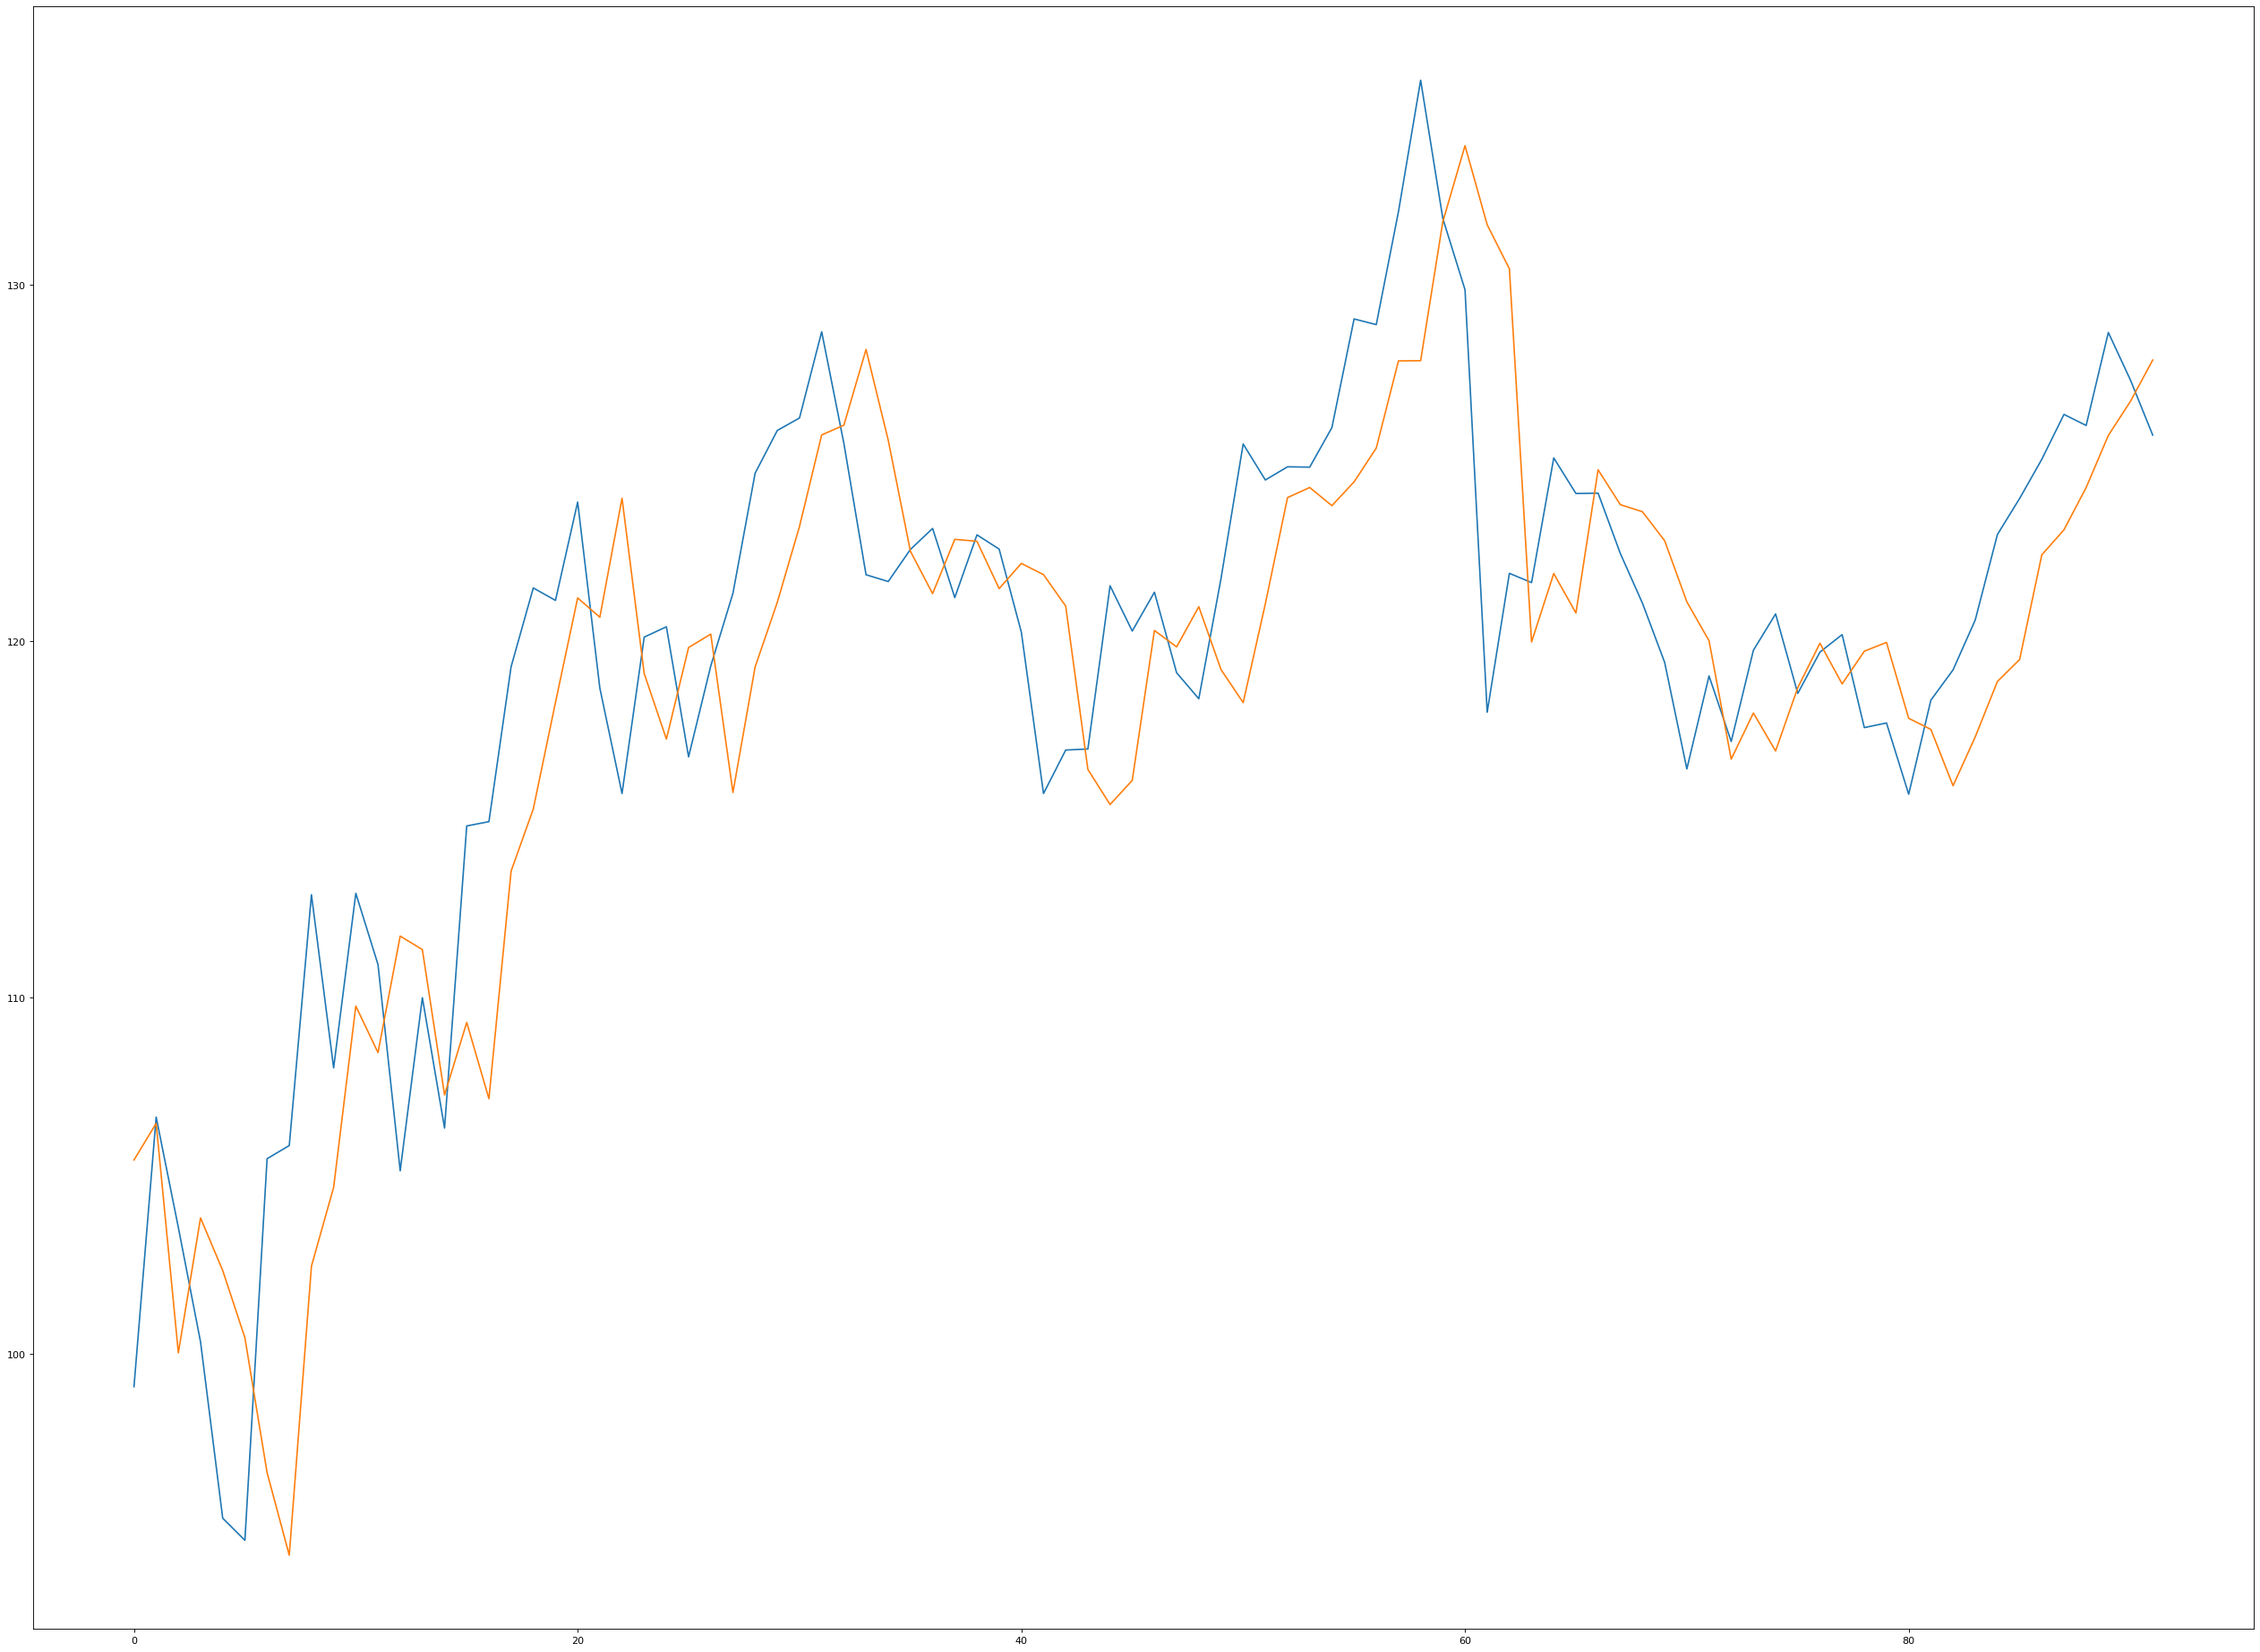

In [39]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Last 8 days + prediction of last 4 days

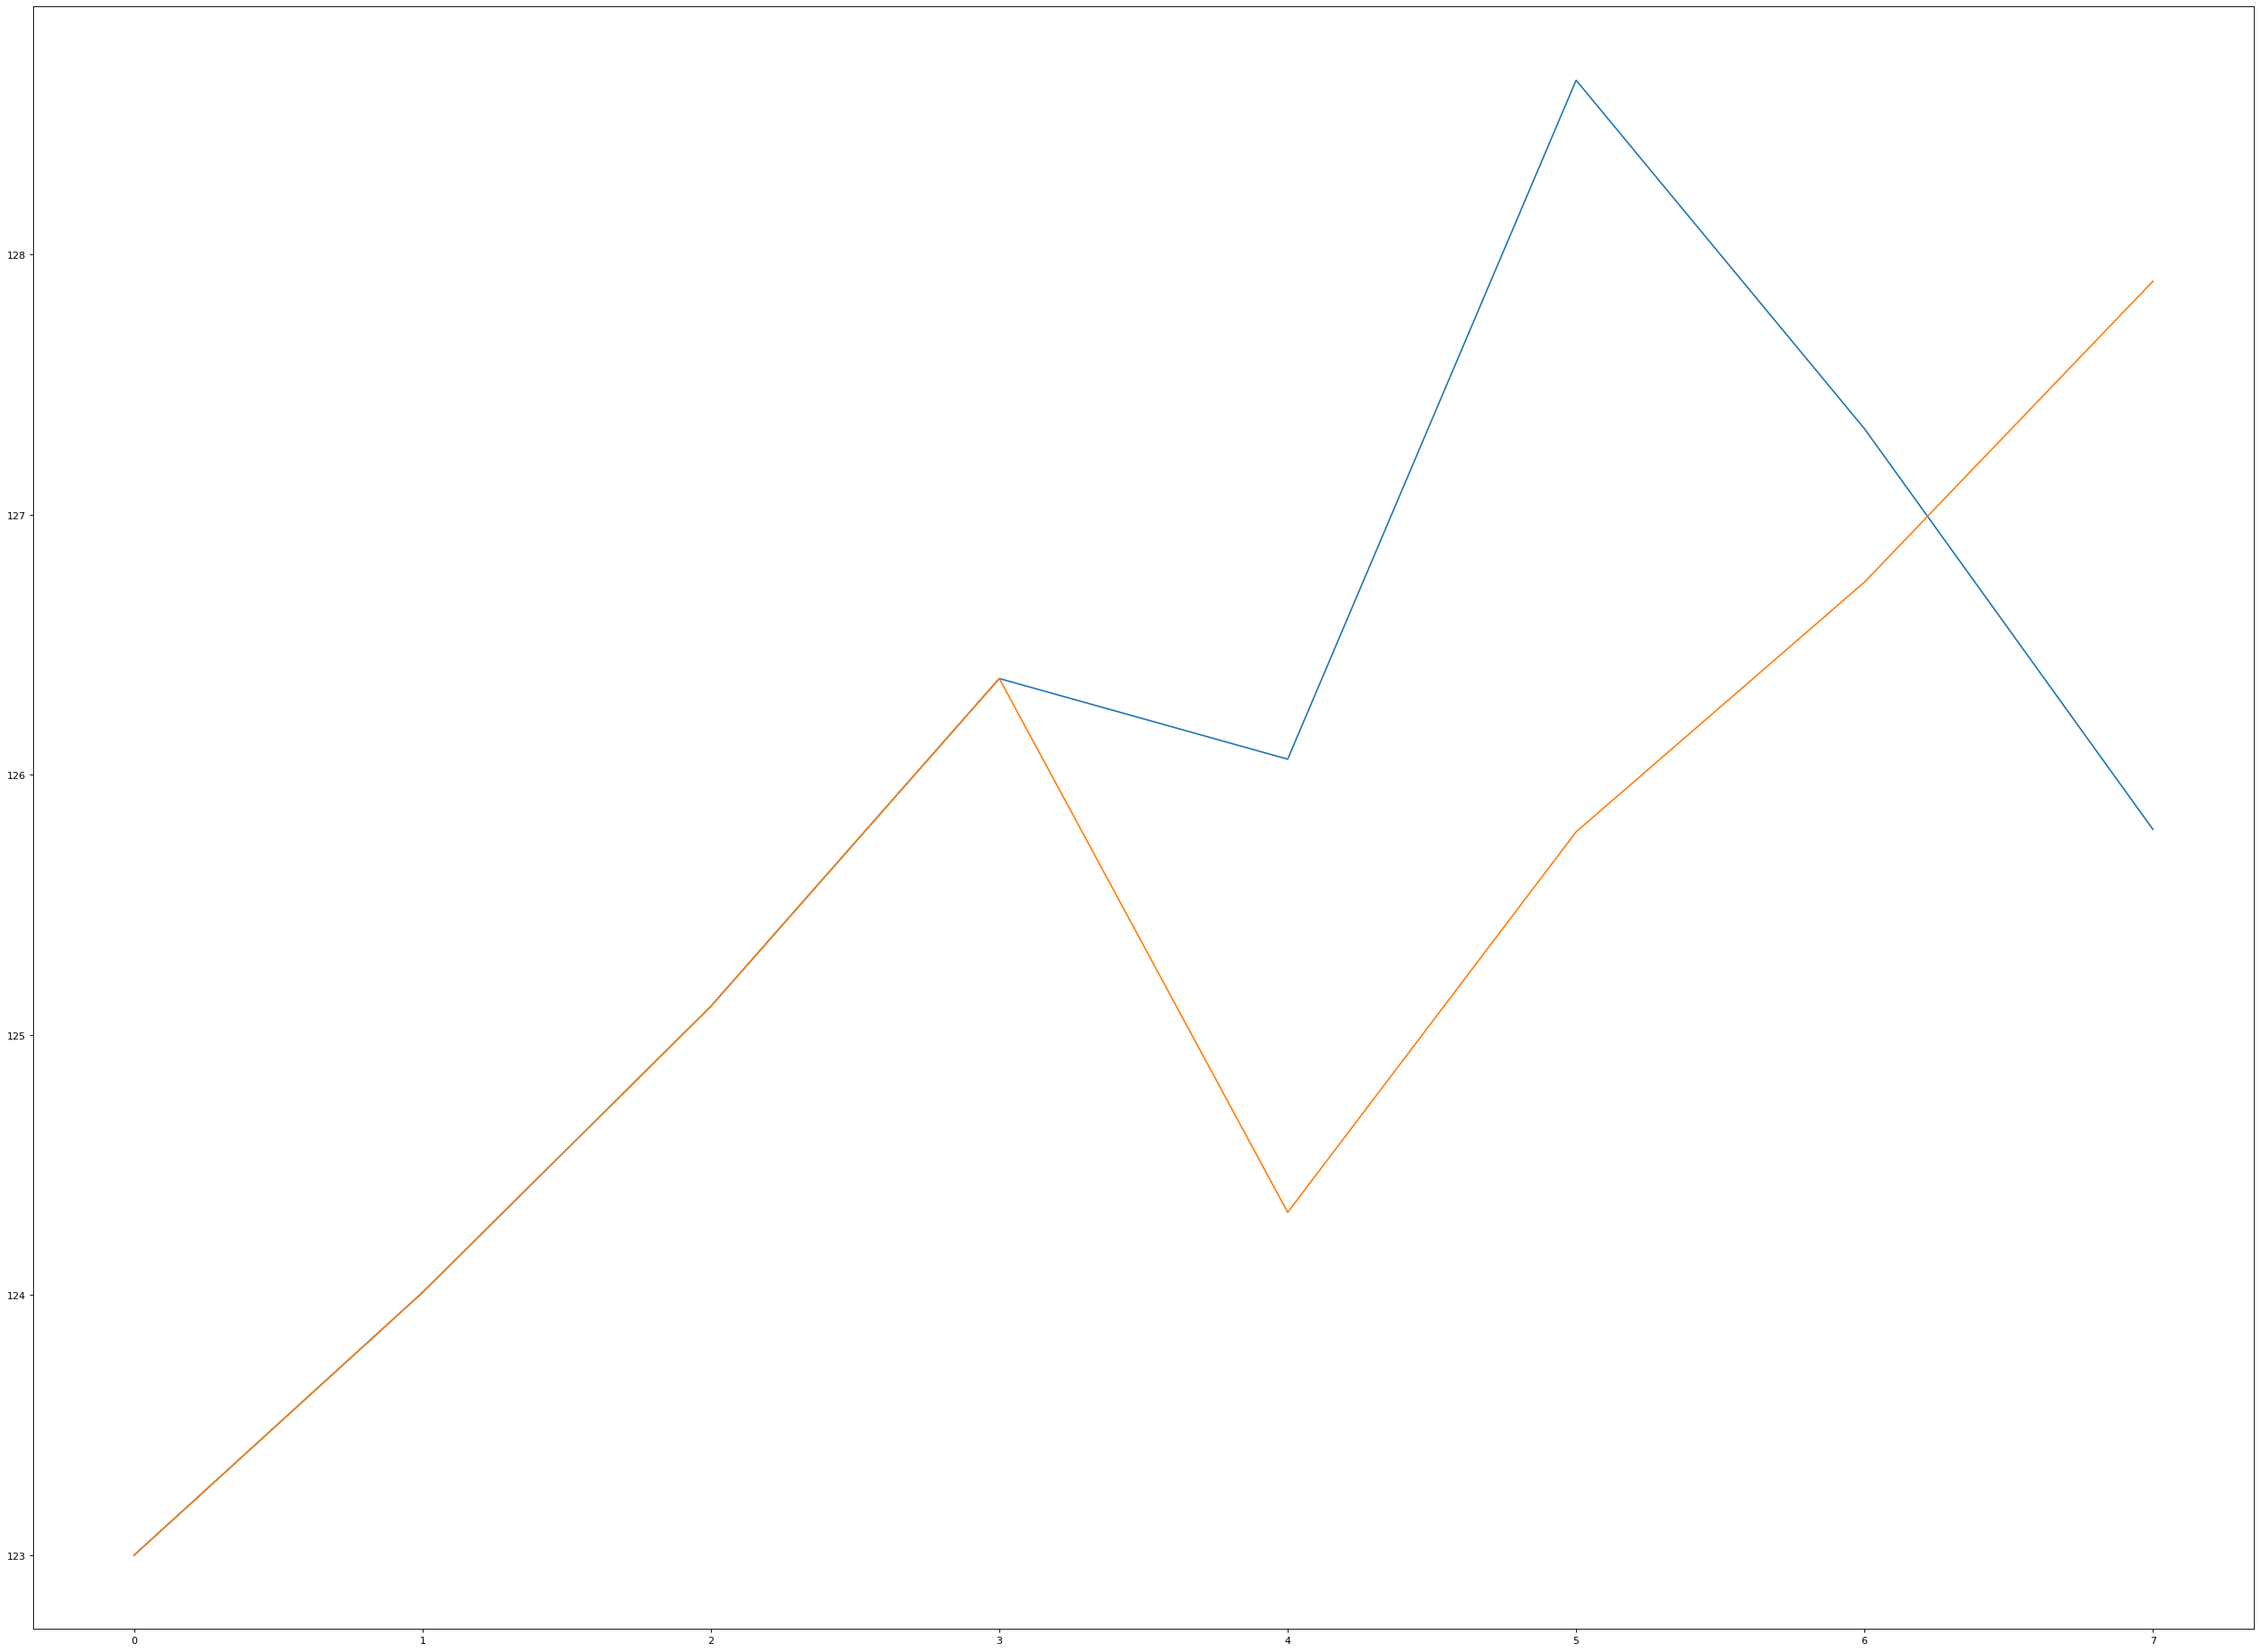

In [40]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(8), true_y_test[-8:])
plt.plot(range(8), np.append(true_y_test[-8:-4], predicted_y_test[-4:]))
plt.show()